# attempt to detect ticked/unticked and circled/not-circled images using openCV

In [ ]:
import importlib
import main
import os
importlib.reload(main)
from main import *
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]


def list_files_in_folder(folder_path, ext=None):
    """
    Returns a list of file names in the given folder, optionally filtering by extension.
    
    Parameters:
        folder_path (str): The path to the folder.
        ext (str, optional): The file extension to filter by (e.g., 'png'). Defaults to None.
        
    Returns:
        list: A list of file names matching the extension.
    """
    try:
        # List all files in the directory
        files = [
            f for f in os.listdir(folder_path)
            if os.path.isfile(os.path.join(folder_path, f))
        ]
        
        if ext is not None:
            # Normalize the extension to lowercase
            ext = ext.lower()
            # Filter files by extension (case-insensitive)
            files = [
                f for f in files
                if os.path.splitext(f)[1].lower() == f'.{ext}'
            ]
        
        return files
    
    except FileNotFoundError:
        print(f"The folder '{folder_path}' does not exist.")
        return []
    except PermissionError:
        print(f"Permission denied to access '{folder_path}'.")
        return []
    



threshold = 60  # Set your desired threshold

folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    print(folder)
    for file_name in image_paths:
        full_file_path = os.path.join(folder, file_name)

        filename = full_file_path.split("/")[-1]
        name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]

        # if name  in unique_strings:
        if name  in unique_strings or 1:
        # break   

            result_payload = process_image(full_file_path, threshold=threshold, show_plots=False)
            LOGGER.info(result_payload)



            # Save the resulting images with green or red text
            output_directory = 'results'
            file_name_prefix = os.path.splitext(os.path.basename(filename))[0]  # Use the original file name as prefix
            image = cv2.imread(full_file_path)
            annotated_image_path = annotate_image_openCV(
                image=image,
                result_payload=result_payload,
                output_path=output_directory,
                file_name_prefix=file_name_prefix,
        )

        

In [3]:
# epsilon_values = [0.01, 0.02, 0.03, 0.05]

# for epsilon_multiplier in epsilon_values:
#     print(f"\nTesting with epsilon_multiplier = {epsilon_multiplier}")
#     tick_detected, detection_info = detect_checkbox_with_tick(
#         gray,
#         area_threshold=100,
#         epsilon_multiplier=epsilon_multiplier,
#         debug=True,
#         show_plots=True
#     )

In [4]:
# param_ranges = {
#     'clahe_clip_limits': [1.0, 1.5, 2.0],
#     'tile_grid_sizes': [(4, 4), (8, 8)],
#     'block_sizes': [15, 21, 31],  # Must be odd numbers
#     'C_values': [2, 3, 5],
#     'area_thresholds': [50, 100, 200]
# }
# full_file_path = "dataset/images_test/no1_93.PNG"
# explore_detection_parameters(full_file_path, param_ranges)

# attempt to use a CNN model and identity detect ticked/unticked and circled/not-circled images

## training the model

INFO:__main__:Loading images from dataset
INFO:__main__:Folder path is /Users/brunoviola/WORK/detect_yes_no_answers/dataset/
INFO:__main__:Processing label: .DS_Store
INFO:__main__:Processing label: ticked
INFO:__main__:Processing label: circled_yes
INFO:__main__:Processing label: images_test
INFO:__main__:Processing label: circled_no
INFO:__main__:Processing label: unticked
INFO:__main__:Labeling images
INFO:__main__:Splitting data into training, validation, and testing
INFO:__main__:Creating CNN model with dropout
/Users/brunoviola/bruvio-tools/.venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
INFO:__main__:Compiling the model
INFO:__main__:Training the model


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.2931 - loss: 1.6433 - val_accuracy: 0.5000 - val_loss: 1.3769 - learning_rate: 0.0010
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 330ms/step - accuracy: 0.3431 - loss: 1.3800 - val_accuracy: 0.5000 - val_loss: 1.3797 - learning_rate: 0.0010
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.3421 - loss: 1.3775 - val_accuracy: 0.5000 - val_loss: 1.3396 - learning_rate: 0.0010
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.3733 - loss: 1.3465 - val_accuracy: 0.5909 - val_loss: 1.2463 - learning_rate: 0.0010
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - accuracy: 0.4057 - loss: 1.2433 - val_accuracy: 0.5909 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 295ms/step - accuracy: 0.5956 - loss: 1.0877 - val_accuracy: 0.6364 - val_loss: 0.8730 - learning_rate: 0.0010
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - accuracy: 0.7037 - loss: 0.9025 - val_acc

INFO:__main__:Evaluating the model


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
              precision    recall  f1-score   support

      ticked       0.94      0.88      0.91        17
    unticked       0.95      0.90      0.92        20
 circled_yes       0.82      1.00      0.90         9
  circled_no       0.89      0.89      0.89         9

    accuracy                           0.91        55
   macro avg       0.90      0.92      0.91        55
weighted avg       0.91      0.91      0.91        55



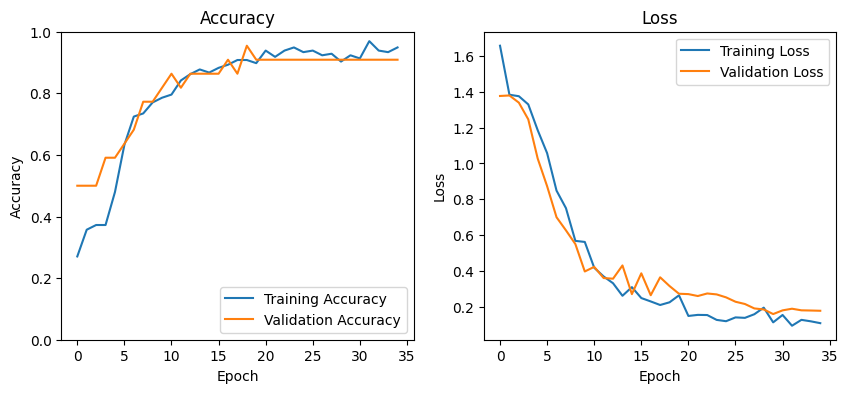

2/2 - 0s - 80ms/step - accuracy: 0.9091 - loss: 0.3471


INFO:__main__:Test accuracy: 0.9090909361839294


In [134]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import logging
import random

# Set the random seeds for reproducibility
os.environ['PYTHONHASHSEED'] = '0'
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Initialize logger
logging.basicConfig(level=logging.INFO)
LOGGER = logging.getLogger(__name__)

# Load and preprocess images
def load_images_from_folder(folder):
    current_dir = os.getcwd()
    folder_path = os.path.join(current_dir, folder)
    LOGGER.info(f"Folder path is {folder_path}")
    images = []
    labels = []
    
    if not os.path.isdir(folder_path):
        raise ValueError(f"Folder {folder_path} does not exist.")
    
    for label in os.listdir(folder_path):
        LOGGER.info(f"Processing label: {label}")
        if label == "images_test":
            continue
        label_folder = os.path.join(folder_path, label)
        if not os.path.isdir(label_folder):
            continue
        
        for filename in os.listdir(label_folder):
            img_path = os.path.join(label_folder, filename)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale
            if img is not None:
                img = cv2.resize(img, (80, 140))  # Resize to 80x140 (width x height) for the model
                images.append(img)
                labels.append(label)
    
    return np.array(images), np.array(labels)

# Load data
LOGGER.info("Loading images from dataset")
image_data, labels = load_images_from_folder('dataset/')
image_data = image_data.reshape(-1, 140, 80, 1)  # Add channel dimension for grayscale
image_data = image_data / 255.0  # Normalize the pixel values

# Convert labels to integers (e.g., ticked=0, unticked=1, circled_yes=2, circled_no=3)
LOGGER.info("Labeling images")
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
labels = np.array([label_mapping[label] for label in labels])

# Split data into training, validation, and testing
LOGGER.info("Splitting data into training, validation, and testing")
X_train_full, X_test, y_train_full, y_test = train_test_split(
    image_data, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)  # 10% of training data for validation

# Compute class weights
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
class_weights = dict(enumerate(class_weights_array))

# Create the CNN model
LOGGER.info("Creating CNN model with dropout")
model = models.Sequential()

# First convolutional block
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(140, 80, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Second convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Third convolutional block
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# Optional pooling layer if needed
# model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))  # Dropout layer added

# Flatten and dense layers
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout layer added
model.add(layers.Dense(4, activation='softmax'))

optimizer = Adam(learning_rate=0.001)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)

# Compile the model
LOGGER.info("Compiling the model")
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
LOGGER.info("Training the model")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights)

# Use classification_report to compute F1-Score, Precision, and Recall
LOGGER.info("Evaluating the model")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
print(classification_report(y_test, y_pred, target_names=label_mapping.keys()))

# Plot training and validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
LOGGER.info(f'Test accuracy: {test_acc}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.AutoLocator object at 0x3200c11b0>


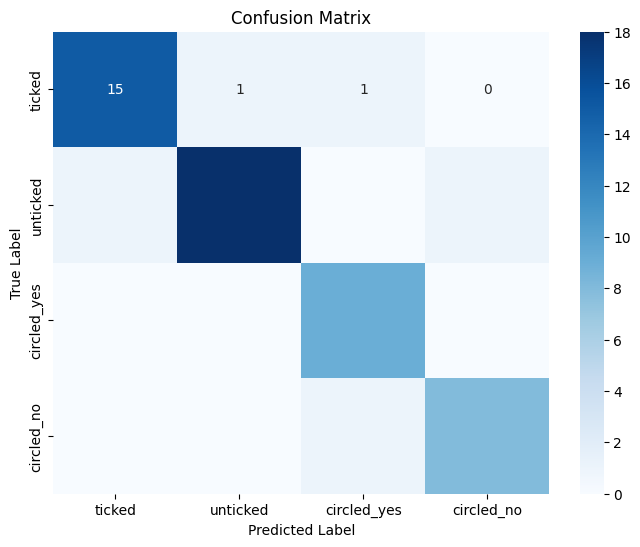

In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get the predicted probabilities
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Now compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create ordered list of class names based on label_mapping
label_mapping = {'ticked': 0, 'unticked': 1, 'circled_yes': 2, 'circled_no': 3}
# Create a list of class names ordered by their label indices
class_names = [''] * len(label_mapping)
for class_name, index in label_mapping.items():
    class_names[index] = class_name

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


## saving the model

In [136]:
# model.save('ticked_box_model.h5')
model.save('ticked_box_model_new.keras')

## load the model

In [137]:


# Load the trained model globally so it's available in subsequent requests
model = tf.keras.models.load_model('ticked_box_model_new.keras')



## predict

In [138]:
import importlib
import main
import os
importlib.reload(main)
from main import *

In [139]:
from io import BytesIO
folder_list = [
    "dataset/images_test",
    "dataset/circled_no",
    "dataset/circled_yes",
    "dataset/unticked",
    "dataset/ticked",
    
]
widths = []
heights = []
aspect_ratios = []
        
threshold = 0.6  
for folder in folder_list:
    image_paths = list_files_in_folder(folder,ext="PNG")

    LOGGER.info(folder)
    for file_name in image_paths:
        LOGGER.info("\n\n")
        full_file_path = os.path.join(folder, file_name)
        LOGGER.info(f"processing image {full_file_path}")
        filename = full_file_path.split("/")[-1]
        image_name = filename.split(".")[0]
        unique_strings = [
        "no1_93",
        "no1_86",
        "yes1_2",
        "no1_96",
        "no1_97",
        "yes1_79",
        "no1_27",
        "no1_2",
        "no4",
        "no1_71",
        "yes1_60",
        "no1_22"
    ]
        

        image = cv2.imread(full_file_path)
        h, w = image.shape[:2]
        widths.append(w)
        heights.append(h)
        aspect_ratios.append(w/h)

        # if name  in unique_strings:

        if name  in unique_strings or 1:
        # break   
            try:
                with open(full_file_path, "rb") as image_file:
                     image_bytes = BytesIO(image_file.read())
                    
                result_payload = process_image_with_model(image_bytes, threshold,model)
                # Build consent dictionary
                consent = build_consent(result_payload, threshold)
                
                # Read the image using OpenCV for annotation
                image = cv2.imread(full_file_path)

                if image is None:
                    LOGGER.error("Failed to read the image for annotation.")
                    
                
                # Prepare annotation parameters
                output_directory = 'results_model'
                file_name_prefix = os.path.splitext(os.path.basename(full_file_path))[0]  # Use the original file name as prefix
                
                # Annotate the image
                annotated_image_path = annotate_image(
                    image=image,
                    consent=consent,
                    output_path=output_directory,
                    file_name_prefix=file_name_prefix
                )
                

            
            except Exception as e:
                LOGGER.exception("An unexpected error occurred in the main workflow.")
                


INFO:main:dataset/images_test
INFO:main:


INFO:main:processing image dataset/images_test/no1_89.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


INFO:main:Raw predictions: ticked 0.34209519624710083 - unticked 0.061205826699733734 - circled_yes 0.09273265302181244 - circled_no 0.5039663314819336
INFO:main:Processed response: {'ticked': 0.34209519624710083, 'unticked': 0.061205826699733734, 'circled_yes': 0.09273265302181244, 'circled_no': 0.5039663314819336}
DEBUG:main:Max label: circled_no with confidence: 0.5039663314819336
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 50.4}
INFO:main:Annotated image saved to results_model/no1_89_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_79.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9994819760322571 - unticked 0.00019457325106486678 - circled_yes 0.00031548761762678623 - circled_no 7.9806904977886e-06
INFO:main:Processed response: {'ticked': 0.9994819760322571, 'unticked': 0.00019457325106486678, 'circled_yes': 0.00031548761762678623, 'circled_no': 7.9806904977886e-06}
DEBUG:main:Max label: ticked with confidence: 0.9994819760322571
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/yes1_79_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_75.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_75_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_70.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.009551726281642914 - unticked 0.9901034832000732 - circled_yes 0.00014225042832549661 - circled_no 0.00020250801753718406
INFO:main:Processed response: {'ticked': 0.009551726281642914, 'unticked': 0.9901034832000732, 'circled_yes': 0.00014225042832549661, 'circled_no': 0.00020250801753718406}
DEBUG:main:Max label: unticked with confidence: 0.9901034832000732
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.01}
INFO:main:Annotated image saved to results_model/no1_70_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_64.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.00015795259969308972 - unticked 0.0029467837885022163 - circled_yes 4.95100648549851e-05 - circled_no 0.9968456625938416
INFO:main:Processed response: {'ticked': 0.00015795259969308972, 'unticked': 0.0029467837885022163, 'circled_yes': 4.95100648549851e-05, 'circled_no': 0.9968456625938416}
DEBUG:main:Max label: circled_no with confidence: 0.9968456625938416
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/no1_64_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_43.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 3.839917553705163e-06 - unticked 9.773140845936723e-06 - circled_yes 0.9999864101409912 - circled_no 1.1057569970773784e-08
INFO:main:Processed response: {'ticked': 3.839917553705163e-06, 'unticked': 9.773140845936723e-06, 'circled_yes': 0.9999864101409912, 'circled_no': 1.1057569970773784e-08}
DEBUG:main:Max label: circled_yes with confidence: 0.9999864101409912
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_43_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_80.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.9938241243362427 - unticked 0.0020185583271086216 - circled_yes 0.003949033096432686 - circled_no 0.00020833482267335057
INFO:main:Processed response: {'ticked': 0.9938241243362427, 'unticked': 0.0020185583271086216, 'circled_yes': 0.003949033096432686, 'circled_no': 0.00020833482267335057}
DEBUG:main:Max label: ticked with confidence: 0.9938241243362427
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.38}
INFO:main:Annotated image saved to results_model/yes1_80_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.5299960970878601 - unticked 0.002091526286676526 - circled_yes 0.4346359372138977 - circled_no 0.03327643498778343
INFO:main:Processed response: {'ticked': 0.5299960970878601, 'unticked': 0.002091526286676526, 'circled_yes': 0.4346359372138977, 'circled_no': 0.03327643498778343}
DEBUG:main:Max label: ticked with confidence: 0.5299960970878601
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 53.0}
INFO:main:Annotated image saved to results_model/no1_2_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_65.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_65_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_71.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.001054346445016563 - unticked 0.9987332224845886 - circled_yes 1.1894360795849934e-05 - circled_no 0.00020046484132762998
INFO:main:Processed response: {'ticked': 0.001054346445016563, 'unticked': 0.9987332224845886, 'circled_yes': 1.1894360795849934e-05, 'circled_no': 0.00020046484132762998}
DEBUG:main:Max label: unticked with confidence: 0.9987332224845886
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.87}
INFO:main:Annotated image saved to results_model/no1_71_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_69.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_69_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_66.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_66_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_26.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_26_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_17.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 1.4298461792350281e-05 - unticked 0.9999653100967407 - circled_yes 6.804079930589069e-07 - circled_no 1.972111567738466e-05
INFO:main:Processed response: {'ticked': 1.4298461792350281e-05, 'unticked': 0.9999653100967407, 'circled_yes': 6.804079930589069e-07, 'circled_no': 1.972111567738466e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999653100967407
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_17_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_34.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_34_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_23.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.0006009800126776099 - unticked 2.985607170558069e-05 - circled_yes 0.9986242055892944 - circled_no 0.0007449685945175588
INFO:main:Processed response: {'ticked': 0.0006009800126776099, 'unticked': 2.985607170558069e-05, 'circled_yes': 0.9986242055892944, 'circled_no': 0.0007449685945175588}
DEBUG:main:Max label: circled_yes with confidence: 0.9986242055892944
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.86}
INFO:main:Annotated image saved to results_model/yes1_23_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_20.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.002437965478748083 - unticked 3.2375323826272506e-06 - circled_yes 0.9975199103355408 - circled_no 3.889875006279908e-05
INFO:main:Processed response: {'ticked': 0.002437965478748083, 'unticked': 3.2375323826272506e-06, 'circled_yes': 0.9975199103355408, 'circled_no': 3.889875006279908e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9975199103355408
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.75}
INFO:main:Annotated image saved to results_model/no1_20_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_22.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:main:Raw predictions: ticked 9.043435420608148e-05 - unticked 0.999908447265625 - circled_yes 5.125592679178226e-07 - circled_no 5.40841540441761e-07
INFO:main:Processed response: {'ticked': 9.043435420608148e-05, 'unticked': 0.999908447265625, 'circled_yes': 5.125592679178226e-07, 'circled_no': 5.40841540441761e-07}
DEBUG:main:Max label: unticked with confidence: 0.999908447265625
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_22_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_27.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


INFO:main:Raw predictions: ticked 0.00317353755235672 - unticked 0.9967868328094482 - circled_yes 6.094242962717544e-06 - circled_no 3.363188443472609e-05
INFO:main:Processed response: {'ticked': 0.00317353755235672, 'unticked': 0.9967868328094482, 'circled_yes': 6.094242962717544e-06, 'circled_no': 3.363188443472609e-05}
DEBUG:main:Max label: unticked with confidence: 0.9967868328094482
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/no1_27_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_25.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 4.320352672948502e-06 - unticked 0.9999945163726807 - circled_yes 7.924114129309601e-07 - circled_no 3.615341483964585e-07
INFO:main:Processed response: {'ticked': 4.320352672948502e-06, 'unticked': 0.9999945163726807, 'circled_yes': 7.924114129309601e-07, 'circled_no': 3.615341483964585e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999945163726807
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_25_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_19.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.00014981326239649206 - unticked 4.524770280678325e-10 - circled_yes 0.9998501539230347 - circled_no 1.3203306004072601e-08
INFO:main:Processed response: {'ticked': 0.00014981326239649206, 'unticked': 4.524770280678325e-10, 'circled_yes': 0.9998501539230347, 'circled_no': 1.3203306004072601e-08}
DEBUG:main:Max label: circled_yes with confidence: 0.9998501539230347
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_19_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_18.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_18_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_70.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9999287128448486 - unticked 4.015906961285509e-05 - circled_yes 8.864271876518615e-06 - circled_no 2.223198680439964e-05
INFO:main:Processed response: {'ticked': 0.9999287128448486, 'unticked': 4.015906961285509e-05, 'circled_yes': 8.864271876518615e-06, 'circled_no': 2.223198680439964e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999287128448486
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_70_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.3346850209927652e-05 - unticked 0.0003618420159909874 - circled_yes 4.5402148316497914e-06 - circled_no 0.9996201992034912
INFO:main:Processed response: {'ticked': 1.3346850209927652e-05, 'unticked': 0.0003618420159909874, 'circled_yes': 4.5402148316497914e-06, 'circled_no': 0.9996201992034912}
DEBUG:main:Max label: circled_no with confidence: 0.9996201992034912
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/no3_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 6.756876973668113e-05 - unticked 0.0011740137124434114 - circled_yes 1.672734651947394e-05 - circled_no 0.9987418055534363
INFO:main:Processed response: {'ticked': 6.756876973668113e-05, 'unticked': 0.0011740137124434114, 'circled_yes': 1.672734651947394e-05, 'circled_no': 0.9987418055534363}
DEBUG:main:Max label: circled_no with confidence: 0.9987418055534363
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.87}
INFO:main:Annotated image saved to results_model/no2_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_65.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.9993670582771301 - unticked 0.0005589730571955442 - circled_yes 8.946412890509237e-06 - circled_no 6.506875797640532e-05
INFO:main:Processed response: {'ticked': 0.9993670582771301, 'unticked': 0.0005589730571955442, 'circled_yes': 8.946412890509237e-06, 'circled_no': 6.506875797640532e-05}
DEBUG:main:Max label: ticked with confidence: 0.9993670582771301
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.94}
INFO:main:Annotated image saved to results_model/yes1_65_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_71.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.9927999973297119 - unticked 0.002161747310310602 - circled_yes 0.0042375377379357815 - circled_no 0.0008006886928342283
INFO:main:Processed response: {'ticked': 0.9927999973297119, 'unticked': 0.002161747310310602, 'circled_yes': 0.0042375377379357815, 'circled_no': 0.0008006886928342283}
DEBUG:main:Max label: ticked with confidence: 0.9927999973297119
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.28}
INFO:main:Annotated image saved to results_model/yes1_71_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_59.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.9997988343238831 - unticked 0.00017323493375442922 - circled_yes 2.227972572654835e-06 - circled_no 2.578377097961493e-05
INFO:main:Processed response: {'ticked': 0.9997988343238831, 'unticked': 0.00017323493375442922, 'circled_yes': 2.227972572654835e-06, 'circled_no': 2.578377097961493e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997988343238831
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_59_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_97.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


INFO:main:Raw predictions: ticked 0.9048739075660706 - unticked 0.09221968054771423 - circled_yes 0.0010517757618799806 - circled_no 0.0018546340288594365
INFO:main:Processed response: {'ticked': 0.9048739075660706, 'unticked': 0.09221968054771423, 'circled_yes': 0.0010517757618799806, 'circled_no': 0.0018546340288594365}
DEBUG:main:Max label: ticked with confidence: 0.9048739075660706
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 90.49}
INFO:main:Annotated image saved to results_model/no1_97_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_73.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_73_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.000599520979449153 - unticked 0.00639601843431592 - circled_yes 0.0007254834054037929 - circled_no 0.992279052734375
INFO:main:Processed response: {'ticked': 0.000599520979449153, 'unticked': 0.00639601843431592, 'circled_yes': 0.0007254834054037929, 'circled_no': 0.992279052734375}
DEBUG:main:Max label: circled_no with confidence: 0.992279052734375
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.23}
INFO:main:Annotated image saved to results_model/no1_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_72.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9984751343727112 - unticked 0.00011626725608948618 - circled_yes 0.0013182528782635927 - circled_no 9.029085049405694e-05
INFO:main:Processed response: {'ticked': 0.9984751343727112, 'unticked': 0.00011626725608948618, 'circled_yes': 0.0013182528782635927, 'circled_no': 9.029085049405694e-05}
DEBUG:main:Max label: ticked with confidence: 0.9984751343727112
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.85}
INFO:main:Annotated image saved to results_model/yes1_72_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_69.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 8.807345693639945e-06 - unticked 0.9999890327453613 - circled_yes 1.6913020317588234e-06 - circled_no 4.820421963813715e-07
INFO:main:Processed response: {'ticked': 8.807345693639945e-06, 'unticked': 0.9999890327453613, 'circled_yes': 1.6913020317588234e-06, 'circled_no': 4.820421963813715e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999890327453613
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_69_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_82.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.00037820605211891234 - unticked 0.003466470632702112 - circled_yes 0.00032637399272061884 - circled_no 0.9958289265632629
INFO:main:Processed response: {'ticked': 0.00037820605211891234, 'unticked': 0.003466470632702112, 'circled_yes': 0.00032637399272061884, 'circled_no': 0.9958289265632629}
DEBUG:main:Max label: circled_no with confidence: 0.9958289265632629
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.58}
INFO:main:Annotated image saved to results_model/no1_82_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_96.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.44641920924186707 - unticked 0.525510847568512 - circled_yes 0.02030833810567856 - circled_no 0.007761663291603327
INFO:main:Processed response: {'ticked': 0.44641920924186707, 'unticked': 0.525510847568512, 'circled_yes': 0.02030833810567856, 'circled_no': 0.007761663291603327}
DEBUG:main:Max label: unticked with confidence: 0.525510847568512
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 52.55}
INFO:main:Annotated image saved to results_model/no1_96_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_86.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 7.533017651439877e-06 - unticked 0.0002175192057620734 - circled_yes 1.6842565173647017e-06 - circled_no 0.9997733235359192
INFO:main:Processed response: {'ticked': 7.533017651439877e-06, 'unticked': 0.0002175192057620734, 'circled_yes': 1.6842565173647017e-06, 'circled_no': 0.9997733235359192}
DEBUG:main:Max label: circled_no with confidence: 0.9997733235359192
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/no1_86_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_76.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.999620795249939 - unticked 0.00029752281261608005 - circled_yes 2.493210013199132e-05 - circled_no 5.665006028721109e-05
INFO:main:Processed response: {'ticked': 0.999620795249939, 'unticked': 0.00029752281261608005, 'circled_yes': 2.493210013199132e-05, 'circled_no': 5.665006028721109e-05}
DEBUG:main:Max label: ticked with confidence: 0.999620795249939
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/yes1_76_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no5.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.8047845514956862e-05 - unticked 0.0004940945073030889 - circled_yes 6.479861440311652e-06 - circled_no 0.9994814991950989
INFO:main:Processed response: {'ticked': 1.8047845514956862e-05, 'unticked': 0.0004940945073030889, 'circled_yes': 6.479861440311652e-06, 'circled_no': 0.9994814991950989}
DEBUG:main:Max label: circled_no with confidence: 0.9994814991950989
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no5_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no4.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 5.265925210551359e-05 - unticked 0.0008920012624002993 - circled_yes 2.7897112886421382e-05 - circled_no 0.9990274906158447
INFO:main:Processed response: {'ticked': 5.265925210551359e-05, 'unticked': 0.0008920012624002993, 'circled_yes': 2.7897112886421382e-05, 'circled_no': 0.9990274906158447}
DEBUG:main:Max label: circled_no with confidence: 0.9990274906158447
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.9}
INFO:main:Annotated image saved to results_model/no4_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_77.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9999085664749146 - unticked 7.908516272436827e-05 - circled_yes 2.191883822888485e-06 - circled_no 1.0158682925975882e-05
INFO:main:Processed response: {'ticked': 0.9999085664749146, 'unticked': 7.908516272436827e-05, 'circled_yes': 2.191883822888485e-06, 'circled_no': 1.0158682925975882e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999085664749146
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_77_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_93.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9911077618598938 - unticked 0.007653546519577503 - circled_yes 0.0004171129548922181 - circled_no 0.0008215709822252393
INFO:main:Processed response: {'ticked': 0.9911077618598938, 'unticked': 0.007653546519577503, 'circled_yes': 0.0004171129548922181, 'circled_no': 0.0008215709822252393}
DEBUG:main:Max label: ticked with confidence: 0.9911077618598938
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.11}
INFO:main:Annotated image saved to results_model/no1_93_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_91.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 1.0477790965524036e-05 - unticked 0.000257196748862043 - circled_yes 1.5234173815770191e-06 - circled_no 0.9997307658195496
INFO:main:Processed response: {'ticked': 1.0477790965524036e-05, 'unticked': 0.000257196748862043, 'circled_yes': 1.5234173815770191e-06, 'circled_no': 0.9997307658195496}
DEBUG:main:Max label: circled_no with confidence: 0.9997307658195496
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.97}
INFO:main:Annotated image saved to results_model/no1_91_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no6.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:main:Raw predictions: ticked 3.5021388612221926e-05 - unticked 0.0005584062892012298 - circled_yes 2.3018987121758983e-05 - circled_no 0.9993835687637329
INFO:main:Processed response: {'ticked': 3.5021388612221926e-05, 'unticked': 0.0005584062892012298, 'circled_yes': 2.3018987121758983e-05, 'circled_no': 0.9993835687637329}
DEBUG:main:Max label: circled_no with confidence: 0.9993835687637329
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.94}
INFO:main:Annotated image saved to results_model/no6_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/no1_8.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


INFO:main:Raw predictions: ticked 0.3634737730026245 - unticked 0.00023683173640165478 - circled_yes 0.6157667636871338 - circled_no 0.020522626116871834
INFO:main:Processed response: {'ticked': 0.3634737730026245, 'unticked': 0.00023683173640165478, 'circled_yes': 0.6157667636871338, 'circled_no': 0.020522626116871834}
DEBUG:main:Max label: circled_yes with confidence: 0.6157667636871338
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 61.58}
INFO:main:Annotated image saved to results_model/no1_8_annotated.png
INFO:main:


INFO:main:processing image dataset/images_test/yes1_60.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


INFO:main:Raw predictions: ticked 0.9997531771659851 - unticked 0.00022147264098748565 - circled_yes 1.2373372555884998e-05 - circled_no 1.3039243640378118e-05
INFO:main:Processed response: {'ticked': 0.9997531771659851, 'unticked': 0.00022147264098748565, 'circled_yes': 1.2373372555884998e-05, 'circled_no': 1.3039243640378118e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997531771659851
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_60_annotated.png
INFO:main:dataset/circled_no
INFO:main:


INFO:main:processing image dataset/circled_no/no1_62.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_62_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_75.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_75_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_46.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:main:Raw predictions: ticked 0.03786146640777588 - unticked 0.05349639803171158 - circled_yes 0.09854591637849808 - circled_no 0.8100961446762085
INFO:main:Processed response: {'ticked': 0.03786146640777588, 'unticked': 0.05349639803171158, 'circled_yes': 0.09854591637849808, 'circled_no': 0.8100961446762085}
DEBUG:main:Max label: circled_no with confidence: 0.8100961446762085
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 81.01}
INFO:main:Annotated image saved to results_model/yes1_46_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_6.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


INFO:main:Raw predictions: ticked 0.0005936582456342876 - unticked 0.0045902845449745655 - circled_yes 0.0003390593337826431 - circled_no 0.9944769740104675
INFO:main:Processed response: {'ticked': 0.0005936582456342876, 'unticked': 0.0045902845449745655, 'circled_yes': 0.0003390593337826431, 'circled_no': 0.9944769740104675}
DEBUG:main:Max label: circled_no with confidence: 0.9944769740104675
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.45}
INFO:main:Annotated image saved to results_model/no1_6_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_7.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.0001245262974407524 - unticked 0.0013585211709141731 - circled_yes 6.558402674272656e-05 - circled_no 0.9984513521194458
INFO:main:Processed response: {'ticked': 0.0001245262974407524, 'unticked': 0.0013585211709141731, 'circled_yes': 6.558402674272656e-05, 'circled_no': 0.9984513521194458}
DEBUG:main:Max label: circled_no with confidence: 0.9984513521194458
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.85}
INFO:main:Annotated image saved to results_model/no1_7_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_64.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.00015795259969308972 - unticked 0.0029467837885022163 - circled_yes 4.95100648549851e-05 - circled_no 0.9968456625938416
INFO:main:Processed response: {'ticked': 0.00015795259969308972, 'unticked': 0.0029467837885022163, 'circled_yes': 4.95100648549851e-05, 'circled_no': 0.9968456625938416}
DEBUG:main:Max label: circled_no with confidence: 0.9968456625938416
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/no1_64_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


INFO:main:Raw predictions: ticked 0.081412173807621 - unticked 0.07323862612247467 - circled_yes 0.07883930206298828 - circled_no 0.7665099501609802
INFO:main:Processed response: {'ticked': 0.081412173807621, 'unticked': 0.07323862612247467, 'circled_yes': 0.07883930206298828, 'circled_no': 0.7665099501609802}
DEBUG:main:Max label: circled_no with confidence: 0.7665099501609802
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 76.65}
INFO:main:Annotated image saved to results_model/yes1_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_56.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.041227906942367554 - unticked 0.007889864034950733 - circled_yes 0.050677891820669174 - circled_no 0.9002043008804321
INFO:main:Processed response: {'ticked': 0.041227906942367554, 'unticked': 0.007889864034950733, 'circled_yes': 0.050677891820669174, 'circled_no': 0.9002043008804321}
DEBUG:main:Max label: circled_no with confidence: 0.9002043008804321
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 90.02}
INFO:main:Annotated image saved to results_model/yes1_56_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1 copy 3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.001069999998435378 - unticked 0.013622167520225048 - circled_yes 0.001672070473432541 - circled_no 0.9836357235908508
INFO:main:Processed response: {'ticked': 0.001069999998435378, 'unticked': 0.013622167520225048, 'circled_yes': 0.001672070473432541, 'circled_no': 0.9836357235908508}
DEBUG:main:Max label: circled_no with confidence: 0.9836357235908508
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.36}
INFO:main:Annotated image saved to results_model/no1 copy 3_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1 copy 2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 1.650241028983146e-05 - unticked 0.0004139832453802228 - circled_yes 7.598495130878291e-07 - circled_no 0.99956876039505
INFO:main:Processed response: {'ticked': 1.650241028983146e-05, 'unticked': 0.0004139832453802228, 'circled_yes': 7.598495130878291e-07, 'circled_no': 0.99956876039505}
DEBUG:main:Max label: circled_no with confidence: 0.99956876039505
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/no1 copy 2_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_8.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.03885500505566597 - unticked 0.00974578782916069 - circled_yes 0.043000634759664536 - circled_no 0.9083986282348633
INFO:main:Processed response: {'ticked': 0.03885500505566597, 'unticked': 0.00974578782916069, 'circled_yes': 0.043000634759664536, 'circled_no': 0.9083986282348633}
DEBUG:main:Max label: circled_no with confidence: 0.9083986282348633
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 90.84}
INFO:main:Annotated image saved to results_model/yes1_8_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_66.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_66_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_15.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 1.650241028983146e-05 - unticked 0.0004139832453802228 - circled_yes 7.598495130878291e-07 - circled_no 0.99956876039505
INFO:main:Processed response: {'ticked': 1.650241028983146e-05, 'unticked': 0.0004139832453802228, 'circled_yes': 7.598495130878291e-07, 'circled_no': 0.99956876039505}
DEBUG:main:Max label: circled_no with confidence: 0.99956876039505
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/no1_15_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_14.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step


INFO:main:Raw predictions: ticked 1.0477790965524036e-05 - unticked 0.000257196748862043 - circled_yes 1.5234173815770191e-06 - circled_no 0.9997307658195496
INFO:main:Processed response: {'ticked': 1.0477790965524036e-05, 'unticked': 0.000257196748862043, 'circled_yes': 1.5234173815770191e-06, 'circled_no': 0.9997307658195496}
DEBUG:main:Max label: circled_no with confidence: 0.9997307658195496
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.97}
INFO:main:Annotated image saved to results_model/no1_14_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no-not-circled1 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 0.001069999998435378 - unticked 0.013622167520225048 - circled_yes 0.001672070473432541 - circled_no 0.9836357235908508
INFO:main:Processed response: {'ticked': 0.001069999998435378, 'unticked': 0.013622167520225048, 'circled_yes': 0.001672070473432541, 'circled_no': 0.9836357235908508}
DEBUG:main:Max label: circled_no with confidence: 0.9836357235908508
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.36}
INFO:main:Annotated image saved to results_model/no-not-circled1 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_104.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.001069999998435378 - unticked 0.013622167520225048 - circled_yes 0.001672070473432541 - circled_no 0.9836357235908508
INFO:main:Processed response: {'ticked': 0.001069999998435378, 'unticked': 0.013622167520225048, 'circled_yes': 0.001672070473432541, 'circled_no': 0.9836357235908508}
DEBUG:main:Max label: circled_no with confidence: 0.9836357235908508
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.36}
INFO:main:Annotated image saved to results_model/no1_104_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no-not-circled1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.001069999998435378 - unticked 0.013622167520225048 - circled_yes 0.001672070473432541 - circled_no 0.9836357235908508
INFO:main:Processed response: {'ticked': 0.001069999998435378, 'unticked': 0.013622167520225048, 'circled_yes': 0.001672070473432541, 'circled_no': 0.9836357235908508}
DEBUG:main:Max label: circled_no with confidence: 0.9836357235908508
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.36}
INFO:main:Annotated image saved to results_model/no-not-circled1_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_30.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.028746040537953377 - unticked 0.008373859338462353 - circled_yes 0.0831938162446022 - circled_no 0.8796862363815308
INFO:main:Processed response: {'ticked': 0.028746040537953377, 'unticked': 0.008373859338462353, 'circled_yes': 0.0831938162446022, 'circled_no': 0.8796862363815308}
DEBUG:main:Max label: circled_no with confidence: 0.8796862363815308
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 87.97}
INFO:main:Annotated image saved to results_model/yes1_30_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_24.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.028746040537953377 - unticked 0.008373859338462353 - circled_yes 0.0831938162446022 - circled_no 0.8796862363815308
INFO:main:Processed response: {'ticked': 0.028746040537953377, 'unticked': 0.008373859338462353, 'circled_yes': 0.0831938162446022, 'circled_no': 0.8796862363815308}
DEBUG:main:Max label: circled_no with confidence: 0.8796862363815308
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 87.97}
INFO:main:Annotated image saved to results_model/yes1_24_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_115.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:main:Raw predictions: ticked 0.0005936582456342876 - unticked 0.0045902845449745655 - circled_yes 0.0003390593337826431 - circled_no 0.9944769740104675
INFO:main:Processed response: {'ticked': 0.0005936582456342876, 'unticked': 0.0045902845449745655, 'circled_yes': 0.0003390593337826431, 'circled_no': 0.9944769740104675}
DEBUG:main:Max label: circled_no with confidence: 0.9944769740104675
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.45}
INFO:main:Annotated image saved to results_model/no1_115_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_13.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.06009292975068092 - unticked 0.2143048793077469 - circled_yes 0.22186419367790222 - circled_no 0.5037379264831543
INFO:main:Processed response: {'ticked': 0.06009292975068092, 'unticked': 0.2143048793077469, 'circled_yes': 0.22186419367790222, 'circled_no': 0.5037379264831543}
DEBUG:main:Max label: circled_no with confidence: 0.5037379264831543
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 50.37}
INFO:main:Annotated image saved to results_model/no1_13_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_116.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_116_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_10.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 8.109795453492552e-05 - unticked 0.0019890926778316498 - circled_yes 4.909003109787591e-05 - circled_no 0.9978806972503662
INFO:main:Processed response: {'ticked': 8.109795453492552e-05, 'unticked': 0.0019890926778316498, 'circled_yes': 4.909003109787591e-05, 'circled_no': 0.9978806972503662}
DEBUG:main:Max label: circled_no with confidence: 0.9978806972503662
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.79}
INFO:main:Annotated image saved to results_model/no1_10_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_103.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.0001264107268070802 - unticked 0.010176523588597775 - circled_yes 0.0042463368736207485 - circled_no 0.9854507446289062
INFO:main:Processed response: {'ticked': 0.0001264107268070802, 'unticked': 0.010176523588597775, 'circled_yes': 0.0042463368736207485, 'circled_no': 0.9854507446289062}
DEBUG:main:Max label: circled_no with confidence: 0.9854507446289062
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.55}
INFO:main:Annotated image saved to results_model/yes1_103_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_36.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 1.495499145676149e-05 - unticked 0.006203027907758951 - circled_yes 0.0005551821668632329 - circled_no 0.9932268261909485
INFO:main:Processed response: {'ticked': 1.495499145676149e-05, 'unticked': 0.006203027907758951, 'circled_yes': 0.0005551821668632329, 'circled_no': 0.9932268261909485}
DEBUG:main:Max label: circled_no with confidence: 0.9932268261909485
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.32}
INFO:main:Annotated image saved to results_model/yes1_36_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_13.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.00025055682635866106 - unticked 0.009979440830647945 - circled_yes 0.005893454421311617 - circled_no 0.9838765263557434
INFO:main:Processed response: {'ticked': 0.00025055682635866106, 'unticked': 0.009979440830647945, 'circled_yes': 0.005893454421311617, 'circled_no': 0.9838765263557434}
DEBUG:main:Max label: circled_no with confidence: 0.9838765263557434
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 98.39}
INFO:main:Annotated image saved to results_model/yes1_13_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_21.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_21_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_119.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_119_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.0015410627238452435 - unticked 0.01657024584710598 - circled_yes 0.0033841633703559637 - circled_no 0.9785045385360718
INFO:main:Processed response: {'ticked': 0.0015410627238452435, 'unticked': 0.01657024584710598, 'circled_yes': 0.0033841633703559637, 'circled_no': 0.9785045385360718}
DEBUG:main:Max label: circled_no with confidence: 0.9785045385360718
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/no1 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_36.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.02175159379839897 - unticked 0.01509577501565218 - circled_yes 0.5866175293922424 - circled_no 0.37653517723083496
INFO:main:Processed response: {'ticked': 0.02175159379839897, 'unticked': 0.01509577501565218, 'circled_yes': 0.5866175293922424, 'circled_no': 0.37653517723083496}
DEBUG:main:Max label: circled_yes with confidence: 0.5866175293922424
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 58.66}
INFO:main:Annotated image saved to results_model/no1_36_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_124.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


INFO:main:Raw predictions: ticked 0.00037820605211891234 - unticked 0.003466470632702112 - circled_yes 0.00032637399272061884 - circled_no 0.9958289265632629
INFO:main:Processed response: {'ticked': 0.00037820605211891234, 'unticked': 0.003466470632702112, 'circled_yes': 0.00032637399272061884, 'circled_no': 0.9958289265632629}
DEBUG:main:Max label: circled_no with confidence: 0.9958289265632629
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.58}
INFO:main:Annotated image saved to results_model/no1_124_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_108.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_108_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_26.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_26_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_121.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.00012023399904137477 - unticked 0.0011414127657189965 - circled_yes 6.974737971177092e-06 - circled_no 0.9987313151359558
INFO:main:Processed response: {'ticked': 0.00012023399904137477, 'unticked': 0.0011414127657189965, 'circled_yes': 6.974737971177092e-06, 'circled_no': 0.9987313151359558}
DEBUG:main:Max label: circled_no with confidence: 0.9987313151359558
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.87}
INFO:main:Annotated image saved to results_model/no1_121_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_30.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 8.850973244989291e-05 - unticked 0.0010041282512247562 - circled_yes 5.028722171118716e-06 - circled_no 0.9989023208618164
INFO:main:Processed response: {'ticked': 8.850973244989291e-05, 'unticked': 0.0010041282512247562, 'circled_yes': 5.028722171118716e-06, 'circled_no': 0.9989023208618164}
DEBUG:main:Max label: circled_no with confidence: 0.9989023208618164
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.89}
INFO:main:Annotated image saved to results_model/no1_30_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_24.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 8.850973244989291e-05 - unticked 0.0010041282512247562 - circled_yes 5.028722171118716e-06 - circled_no 0.9989023208618164
INFO:main:Processed response: {'ticked': 8.850973244989291e-05, 'unticked': 0.0010041282512247562, 'circled_yes': 5.028722171118716e-06, 'circled_no': 0.9989023208618164}
DEBUG:main:Max label: circled_no with confidence: 0.9989023208618164
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.89}
INFO:main:Annotated image saved to results_model/no1_24_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_122.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 7.533017651439877e-06 - unticked 0.0002175192057620734 - circled_yes 1.6842565173647017e-06 - circled_no 0.9997733235359192
INFO:main:Processed response: {'ticked': 7.533017651439877e-06, 'unticked': 0.0002175192057620734, 'circled_yes': 1.6842565173647017e-06, 'circled_no': 0.9997733235359192}
DEBUG:main:Max label: circled_no with confidence: 0.9997733235359192
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/no1_122_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_94.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_94_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_43.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 7.307417490665102e-06 - unticked 0.00039468149770982563 - circled_yes 9.84363396128174e-07 - circled_no 0.9995971322059631
INFO:main:Processed response: {'ticked': 7.307417490665102e-06, 'unticked': 0.00039468149770982563, 'circled_yes': 9.84363396128174e-07, 'circled_no': 0.9995971322059631}
DEBUG:main:Max label: circled_no with confidence: 0.9995971322059631
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/no1_43_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.3346850209927652e-05 - unticked 0.0003618420159909874 - circled_yes 4.5402148316497914e-06 - circled_no 0.9996201992034912
INFO:main:Processed response: {'ticked': 1.3346850209927652e-05, 'unticked': 0.0003618420159909874, 'circled_yes': 4.5402148316497914e-06, 'circled_no': 0.9996201992034912}
DEBUG:main:Max label: circled_no with confidence: 0.9996201992034912
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/no3_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 6.756876973668113e-05 - unticked 0.0011740137124434114 - circled_yes 1.672734651947394e-05 - circled_no 0.9987418055534363
INFO:main:Processed response: {'ticked': 6.756876973668113e-05, 'unticked': 0.0011740137124434114, 'circled_yes': 1.672734651947394e-05, 'circled_no': 0.9987418055534363}
DEBUG:main:Max label: circled_no with confidence: 0.9987418055534363
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.87}
INFO:main:Annotated image saved to results_model/no2_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_56.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 2.7010364647139795e-05 - unticked 0.0005393699975684285 - circled_yes 2.7939706797042163e-06 - circled_no 0.9994308352470398
INFO:main:Processed response: {'ticked': 2.7010364647139795e-05, 'unticked': 0.0005393699975684285, 'circled_yes': 2.7939706797042163e-06, 'circled_no': 0.9994308352470398}
DEBUG:main:Max label: circled_no with confidence: 0.9994308352470398
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.94}
INFO:main:Annotated image saved to results_model/no1_56_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no-not-circled copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.0015410627238452435 - unticked 0.01657024584710598 - circled_yes 0.0033841633703559637 - circled_no 0.9785045385360718
INFO:main:Processed response: {'ticked': 0.0015410627238452435, 'unticked': 0.01657024584710598, 'circled_yes': 0.0033841633703559637, 'circled_no': 0.9785045385360718}
DEBUG:main:Max label: circled_no with confidence: 0.9785045385360718
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/no-not-circled copy_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_6.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.15692560374736786 - unticked 0.17280051112174988 - circled_yes 0.03998502343893051 - circled_no 0.63028883934021
INFO:main:Processed response: {'ticked': 0.15692560374736786, 'unticked': 0.17280051112174988, 'circled_yes': 0.03998502343893051, 'circled_no': 0.63028883934021}
DEBUG:main:Max label: circled_no with confidence: 0.63028883934021
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 63.03}
INFO:main:Annotated image saved to results_model/yes1_6_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.000599520979449153 - unticked 0.00639601843431592 - circled_yes 0.0007254834054037929 - circled_no 0.992279052734375
INFO:main:Processed response: {'ticked': 0.000599520979449153, 'unticked': 0.00639601843431592, 'circled_yes': 0.0007254834054037929, 'circled_no': 0.992279052734375}
DEBUG:main:Max label: circled_no with confidence: 0.992279052734375
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.23}
INFO:main:Annotated image saved to results_model/no1_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_99.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.030246727168560028 - unticked 0.007968737743794918 - circled_yes 0.02830011025071144 - circled_no 0.9334844946861267
INFO:main:Processed response: {'ticked': 0.030246727168560028, 'unticked': 0.007968737743794918, 'circled_yes': 0.02830011025071144, 'circled_no': 0.9334844946861267}
DEBUG:main:Max label: circled_no with confidence: 0.9334844946861267
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 93.35}
INFO:main:Annotated image saved to results_model/yes1_99_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_82.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.00037820605211891234 - unticked 0.003466470632702112 - circled_yes 0.00032637399272061884 - circled_no 0.9958289265632629
INFO:main:Processed response: {'ticked': 0.00037820605211891234, 'unticked': 0.003466470632702112, 'circled_yes': 0.00032637399272061884, 'circled_no': 0.9958289265632629}
DEBUG:main:Max label: circled_no with confidence: 0.9958289265632629
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.58}
INFO:main:Annotated image saved to results_model/no1_82_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_86.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 7.533017651439877e-06 - unticked 0.0002175192057620734 - circled_yes 1.6842565173647017e-06 - circled_no 0.9997733235359192
INFO:main:Processed response: {'ticked': 7.533017651439877e-06, 'unticked': 0.0002175192057620734, 'circled_yes': 1.6842565173647017e-06, 'circled_no': 0.9997733235359192}
DEBUG:main:Max label: circled_no with confidence: 0.9997733235359192
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/no1_86_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no5.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 1.8047845514956862e-05 - unticked 0.0004940945073030889 - circled_yes 6.479861440311652e-06 - circled_no 0.9994814991950989
INFO:main:Processed response: {'ticked': 1.8047845514956862e-05, 'unticked': 0.0004940945073030889, 'circled_yes': 6.479861440311652e-06, 'circled_no': 0.9994814991950989}
DEBUG:main:Max label: circled_no with confidence: 0.9994814991950989
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no5_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.059990860521793365 - unticked 0.07289666682481766 - circled_yes 0.07668893039226532 - circled_no 0.790423572063446
INFO:main:Processed response: {'ticked': 0.059990860521793365, 'unticked': 0.07289666682481766, 'circled_yes': 0.07668893039226532, 'circled_no': 0.790423572063446}
DEBUG:main:Max label: circled_no with confidence: 0.790423572063446
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 79.04}
INFO:main:Annotated image saved to results_model/yes1_2_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no4.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 5.265925210551359e-05 - unticked 0.0008920012624002993 - circled_yes 2.7897112886421382e-05 - circled_no 0.9990274906158447
INFO:main:Processed response: {'ticked': 5.265925210551359e-05, 'unticked': 0.0008920012624002993, 'circled_yes': 2.7897112886421382e-05, 'circled_no': 0.9990274906158447}
DEBUG:main:Max label: circled_no with confidence: 0.9990274906158447
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.9}
INFO:main:Annotated image saved to results_model/no4_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no-not-circled.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:main:Raw predictions: ticked 0.0015410627238452435 - unticked 0.01657024584710598 - circled_yes 0.0033841633703559637 - circled_no 0.9785045385360718
INFO:main:Processed response: {'ticked': 0.0015410627238452435, 'unticked': 0.01657024584710598, 'circled_yes': 0.0033841633703559637, 'circled_no': 0.9785045385360718}
DEBUG:main:Max label: circled_no with confidence: 0.9785045385360718
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/no-not-circled_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_91.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.0477790965524036e-05 - unticked 0.000257196748862043 - circled_yes 1.5234173815770191e-06 - circled_no 0.9997307658195496
INFO:main:Processed response: {'ticked': 1.0477790965524036e-05, 'unticked': 0.000257196748862043, 'circled_yes': 1.5234173815770191e-06, 'circled_no': 0.9997307658195496}
DEBUG:main:Max label: circled_no with confidence: 0.9997307658195496
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.97}
INFO:main:Annotated image saved to results_model/no1_91_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/yes1_61.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.05441555380821228 - unticked 0.04625583067536354 - circled_yes 0.037603843957185745 - circled_no 0.8617247939109802
INFO:main:Processed response: {'ticked': 0.05441555380821228, 'unticked': 0.04625583067536354, 'circled_yes': 0.037603843957185745, 'circled_no': 0.8617247939109802}
DEBUG:main:Max label: circled_no with confidence: 0.8617247939109802
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 86.17}
INFO:main:Annotated image saved to results_model/yes1_61_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no6.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 3.5021388612221926e-05 - unticked 0.0005584062892012298 - circled_yes 2.3018987121758983e-05 - circled_no 0.9993835687637329
INFO:main:Processed response: {'ticked': 3.5021388612221926e-05, 'unticked': 0.0005584062892012298, 'circled_yes': 2.3018987121758983e-05, 'circled_no': 0.9993835687637329}
DEBUG:main:Max label: circled_no with confidence: 0.9993835687637329
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.94}
INFO:main:Annotated image saved to results_model/no6_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_no/no1_53.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 1.0477790965524036e-05 - unticked 0.000257196748862043 - circled_yes 1.5234173815770191e-06 - circled_no 0.9997307658195496
INFO:main:Processed response: {'ticked': 1.0477790965524036e-05, 'unticked': 0.000257196748862043, 'circled_yes': 1.5234173815770191e-06, 'circled_no': 0.9997307658195496}
DEBUG:main:Max label: circled_no with confidence: 0.9997307658195496
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.97}
INFO:main:Annotated image saved to results_model/no1_53_annotated.png
INFO:main:dataset/circled_yes
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_92.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 2.6948593096626228e-12 - unticked 6.985044070521905e-15 - circled_yes 1.0 - circled_no 1.9259253480202743e-12
INFO:main:Processed response: {'ticked': 2.6948593096626228e-12, 'unticked': 6.985044070521905e-15, 'circled_yes': 1.0, 'circled_no': 1.9259253480202743e-12}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_92_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes6.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 4.241233142465717e-09 - unticked 2.2205011267206753e-12 - circled_yes 1.0 - circled_no 1.7095843629633123e-09
INFO:main:Processed response: {'ticked': 4.241233142465717e-09, 'unticked': 2.2205011267206753e-12, 'circled_yes': 1.0, 'circled_no': 1.7095843629633123e-09}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes6_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_87.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.7519744233140955e-07 - unticked 4.1266766004355304e-08 - circled_yes 0.9999997615814209 - circled_no 1.1556731127626563e-09
INFO:main:Processed response: {'ticked': 1.7519744233140955e-07, 'unticked': 4.1266766004355304e-08, 'circled_yes': 0.9999997615814209, 'circled_no': 1.1556731127626563e-09}
DEBUG:main:Max label: circled_yes with confidence: 0.9999997615814209
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_87_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_50.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.008939968422055244 - unticked 2.428416337352246e-05 - circled_yes 0.9910287261009216 - circled_no 7.123907380446326e-06
INFO:main:Processed response: {'ticked': 0.008939968422055244, 'unticked': 2.428416337352246e-05, 'circled_yes': 0.9910287261009216, 'circled_no': 7.123907380446326e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9910287261009216
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.1}
INFO:main:Annotated image saved to results_model/yes1_50_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/no1_49.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.002437965478748083 - unticked 3.2375323826272506e-06 - circled_yes 0.9975199103355408 - circled_no 3.889875006279908e-05
INFO:main:Processed response: {'ticked': 0.002437965478748083, 'unticked': 3.2375323826272506e-06, 'circled_yes': 0.9975199103355408, 'circled_no': 3.889875006279908e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9975199103355408
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.75}
INFO:main:Annotated image saved to results_model/no1_49_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/no1_61.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.002628996269777417 - unticked 7.88850084063597e-05 - circled_yes 0.9972903728485107 - circled_no 1.7374646859025233e-06
INFO:main:Processed response: {'ticked': 0.002628996269777417, 'unticked': 7.88850084063597e-05, 'circled_yes': 0.9972903728485107, 'circled_no': 1.7374646859025233e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9972903728485107
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.73}
INFO:main:Annotated image saved to results_model/no1_61_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_91.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.0006009800126776099 - unticked 2.985607170558069e-05 - circled_yes 0.9986242055892944 - circled_no 0.0007449685945175588
INFO:main:Processed response: {'ticked': 0.0006009800126776099, 'unticked': 2.985607170558069e-05, 'circled_yes': 0.9986242055892944, 'circled_no': 0.0007449685945175588}
DEBUG:main:Max label: circled_yes with confidence: 0.9986242055892944
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.86}
INFO:main:Annotated image saved to results_model/yes1_91_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes5.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 5.884857046112302e-08 - unticked 1.6061786029344417e-15 - circled_yes 1.0 - circled_no 6.625965998097172e-09
INFO:main:Processed response: {'ticked': 5.884857046112302e-08, 'unticked': 1.6061786029344417e-15, 'circled_yes': 1.0, 'circled_no': 6.625965998097172e-09}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes5_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes4.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.6047000883645524e-07 - unticked 2.97729130238622e-09 - circled_yes 0.9999998807907104 - circled_no 4.666848574252924e-10
INFO:main:Processed response: {'ticked': 1.6047000883645524e-07, 'unticked': 2.97729130238622e-09, 'circled_yes': 0.9999998807907104, 'circled_no': 4.666848574252924e-10}
DEBUG:main:Max label: circled_yes with confidence: 0.9999998807907104
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes4_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_53.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 2.6948593096626228e-12 - unticked 6.985044070521905e-15 - circled_yes 1.0 - circled_no 1.9259253480202743e-12
INFO:main:Processed response: {'ticked': 2.6948593096626228e-12, 'unticked': 6.985044070521905e-15, 'circled_yes': 1.0, 'circled_no': 1.9259253480202743e-12}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_53_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1 copy 2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.0005388305289670825 - unticked 0.00023971284099388868 - circled_yes 0.9895778894424438 - circled_no 0.009643523022532463
INFO:main:Processed response: {'ticked': 0.0005388305289670825, 'unticked': 0.00023971284099388868, 'circled_yes': 0.9895778894424438, 'circled_no': 0.009643523022532463}
DEBUG:main:Max label: circled_yes with confidence: 0.9895778894424438
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.96}
INFO:main:Annotated image saved to results_model/yes1 copy 2_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_43.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 3.839917553705163e-06 - unticked 9.773140845936723e-06 - circled_yes 0.9999864101409912 - circled_no 1.1057569970773784e-08
INFO:main:Processed response: {'ticked': 3.839917553705163e-06, 'unticked': 9.773140845936723e-06, 'circled_yes': 0.9999864101409912, 'circled_no': 1.1057569970773784e-08}
DEBUG:main:Max label: circled_yes with confidence: 0.9999864101409912
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_43_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.0009109992533922195 - unticked 9.375097579322755e-05 - circled_yes 0.9862325191497803 - circled_no 0.012762722559273243
INFO:main:Processed response: {'ticked': 0.0009109992533922195, 'unticked': 9.375097579322755e-05, 'circled_yes': 0.9862325191497803, 'circled_no': 0.012762722559273243}
DEBUG:main:Max label: circled_yes with confidence: 0.9862325191497803
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.62}
INFO:main:Annotated image saved to results_model/yes1_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_95.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_95_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/no1_98.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.0004532831662800163 - unticked 1.8120435640867072e-07 - circled_yes 0.9995386600494385 - circled_no 7.900905984570272e-06
INFO:main:Processed response: {'ticked': 0.0004532831662800163, 'unticked': 1.8120435640867072e-07, 'circled_yes': 0.9995386600494385, 'circled_no': 7.900905984570272e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9995386600494385
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_98_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 7.051077777209258e-11 - unticked 2.2217101383906105e-18 - circled_yes 1.0 - circled_no 1.9800049187029822e-12
INFO:main:Processed response: {'ticked': 7.051077777209258e-11, 'unticked': 2.2217101383906105e-18, 'circled_yes': 1.0, 'circled_no': 1.9800049187029822e-12}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes3_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 1.769797997042133e-08 - unticked 9.962174314648298e-12 - circled_yes 1.0 - circled_no 9.546451629205421e-09
INFO:main:Processed response: {'ticked': 1.769797997042133e-08, 'unticked': 9.962174314648298e-12, 'circled_yes': 1.0, 'circled_no': 9.546451629205421e-09}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes2_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_82.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 1.295411444779404e-09 - unticked 5.281921953851146e-14 - circled_yes 1.0 - circled_no 1.3369503282234518e-09
INFO:main:Processed response: {'ticked': 1.295411444779404e-09, 'unticked': 5.281921953851146e-14, 'circled_yes': 1.0, 'circled_no': 1.3369503282234518e-09}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_82_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_106.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.0005388305289670825 - unticked 0.00023971284099388868 - circled_yes 0.9895778894424438 - circled_no 0.009643523022532463
INFO:main:Processed response: {'ticked': 0.0005388305289670825, 'unticked': 0.00023971284099388868, 'circled_yes': 0.9895778894424438, 'circled_no': 0.009643523022532463}
DEBUG:main:Max label: circled_yes with confidence: 0.9895778894424438
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.96}
INFO:main:Annotated image saved to results_model/yes1_106_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_26.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_26_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_19.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 1.926028130386226e-12 - unticked 7.291720713525679e-16 - circled_yes 1.0 - circled_no 8.129726059014075e-12
INFO:main:Processed response: {'ticked': 1.926028130386226e-12, 'unticked': 7.291720713525679e-16, 'circled_yes': 1.0, 'circled_no': 8.129726059014075e-12}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_19_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.001104043796658516 - unticked 3.368112733159734e-11 - circled_yes 0.9988817572593689 - circled_no 1.4224855476641096e-05
INFO:main:Processed response: {'ticked': 0.001104043796658516, 'unticked': 3.368112733159734e-11, 'circled_yes': 0.9988817572593689, 'circled_no': 1.4224855476641096e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9988817572593689
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.89}
INFO:main:Annotated image saved to results_model/yes1 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_110.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_110_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_20.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.00013288894842844456 - unticked 2.1127499749695744e-08 - circled_yes 0.9998064637184143 - circled_no 6.061374369892292e-05
INFO:main:Processed response: {'ticked': 0.00013288894842844456, 'unticked': 2.1127499749695744e-08, 'circled_yes': 0.9998064637184143, 'circled_no': 6.061374369892292e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9998064637184143
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_20_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_34.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_34_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_21.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_21_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes-circled.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.0009109992533922195 - unticked 9.375097579322755e-05 - circled_yes 0.9862325191497803 - circled_no 0.012762722559273243
INFO:main:Processed response: {'ticked': 0.0009109992533922195, 'unticked': 9.375097579322755e-05, 'circled_yes': 0.9862325191497803, 'circled_no': 0.012762722559273243}
DEBUG:main:Max label: circled_yes with confidence: 0.9862325191497803
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.62}
INFO:main:Annotated image saved to results_model/yes-circled_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_23.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.0006009800126776099 - unticked 2.985607170558069e-05 - circled_yes 0.9986242055892944 - circled_no 0.0007449685945175588
INFO:main:Processed response: {'ticked': 0.0006009800126776099, 'unticked': 2.985607170558069e-05, 'circled_yes': 0.9986242055892944, 'circled_no': 0.0007449685945175588}
DEBUG:main:Max label: circled_yes with confidence: 0.9986242055892944
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.86}
INFO:main:Annotated image saved to results_model/yes1_23_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/no1_23.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.0006378541584126651 - unticked 4.518363766692346e-06 - circled_yes 0.9992411136627197 - circled_no 0.00011652212560875341
INFO:main:Processed response: {'ticked': 0.0006378541584126651, 'unticked': 4.518363766692346e-06, 'circled_yes': 0.9992411136627197, 'circled_no': 0.00011652212560875341}
DEBUG:main:Max label: circled_yes with confidence: 0.9992411136627197
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.92}
INFO:main:Annotated image saved to results_model/no1_23_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_10.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.01957501843571663 - unticked 5.720249191654148e-06 - circled_yes 0.9800651669502258 - circled_no 0.0003540741454344243
INFO:main:Processed response: {'ticked': 0.01957501843571663, 'unticked': 5.720249191654148e-06, 'circled_yes': 0.9800651669502258, 'circled_no': 0.0003540741454344243}
DEBUG:main:Max label: circled_yes with confidence: 0.9800651669502258
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.01}
INFO:main:Annotated image saved to results_model/yes1_10_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_15.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.001104043796658516 - unticked 3.368112733159734e-11 - circled_yes 0.9988817572593689 - circled_no 1.4224855476641096e-05
INFO:main:Processed response: {'ticked': 0.001104043796658516, 'unticked': 3.368112733159734e-11, 'circled_yes': 0.9988817572593689, 'circled_no': 1.4224855476641096e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9988817572593689
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.89}
INFO:main:Annotated image saved to results_model/yes1_15_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_14.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 2.6948593096626228e-12 - unticked 6.985044070521905e-15 - circled_yes 1.0 - circled_no 1.9259253480202743e-12
INFO:main:Processed response: {'ticked': 2.6948593096626228e-12, 'unticked': 6.985044070521905e-15, 'circled_yes': 1.0, 'circled_no': 1.9259253480202743e-12}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_14_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes-circled copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.0009109992533922195 - unticked 9.375097579322755e-05 - circled_yes 0.9862325191497803 - circled_no 0.012762722559273243
INFO:main:Processed response: {'ticked': 0.0009109992533922195, 'unticked': 9.375097579322755e-05, 'circled_yes': 0.9862325191497803, 'circled_no': 0.012762722559273243}
DEBUG:main:Max label: circled_yes with confidence: 0.9862325191497803
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.62}
INFO:main:Annotated image saved to results_model/yes-circled copy_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_64.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


INFO:main:Raw predictions: ticked 0.00012194526789244264 - unticked 2.3841931096058033e-08 - circled_yes 0.9998195767402649 - circled_no 5.853749098605476e-05
INFO:main:Processed response: {'ticked': 0.00012194526789244264, 'unticked': 2.3841931096058033e-08, 'circled_yes': 0.9998195767402649, 'circled_no': 5.853749098605476e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9998195767402649
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_64_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1-cicled.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.0005388305289670825 - unticked 0.00023971284099388868 - circled_yes 0.9895778894424438 - circled_no 0.009643523022532463
INFO:main:Processed response: {'ticked': 0.0005388305289670825, 'unticked': 0.00023971284099388868, 'circled_yes': 0.9895778894424438, 'circled_no': 0.009643523022532463}
DEBUG:main:Max label: circled_yes with confidence: 0.9895778894424438
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 98.96}
INFO:main:Annotated image saved to results_model/yes1-cicled_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_7.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 6.303022992426577e-09 - unticked 7.074210661706104e-10 - circled_yes 1.0 - circled_no 1.842226815540471e-08
INFO:main:Processed response: {'ticked': 6.303022992426577e-09, 'unticked': 7.074210661706104e-10, 'circled_yes': 1.0, 'circled_no': 1.842226815540471e-08}
DEBUG:main:Max label: circled_yes with confidence: 1.0
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_7_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_66.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_66_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_62.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_62_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/no1_46.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.028623370453715324 - unticked 1.7616888726479374e-05 - circled_yes 0.9711900949478149 - circled_no 0.00016888626851141453
INFO:main:Processed response: {'ticked': 0.028623370453715324, 'unticked': 1.7616888726479374e-05, 'circled_yes': 0.9711900949478149, 'circled_no': 0.00016888626851141453}
DEBUG:main:Max label: circled_yes with confidence: 0.9711900949478149
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 97.12}
INFO:main:Annotated image saved to results_model/no1_46_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_75.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 6.752906301699113e-06 - unticked 3.6817069485550746e-05 - circled_yes 0.9999465942382812 - circled_no 9.740259883983526e-06
INFO:main:Processed response: {'ticked': 6.752906301699113e-06, 'unticked': 3.6817069485550746e-05, 'circled_yes': 0.9999465942382812, 'circled_no': 9.740259883983526e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9999465942382812
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_75_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/yes1_49.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.00013288894842844456 - unticked 2.1127499749695744e-08 - circled_yes 0.9998064637184143 - circled_no 6.061374369892292e-05
INFO:main:Processed response: {'ticked': 0.00013288894842844456, 'unticked': 2.1127499749695744e-08, 'circled_yes': 0.9998064637184143, 'circled_no': 6.061374369892292e-05}
DEBUG:main:Max label: circled_yes with confidence: 0.9998064637184143
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_49_annotated.png
INFO:main:


INFO:main:processing image dataset/circled_yes/no1_90.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.0006378541584126651 - unticked 4.518363766692346e-06 - circled_yes 0.9992411136627197 - circled_no 0.00011652212560875341
INFO:main:Processed response: {'ticked': 0.0006378541584126651, 'unticked': 4.518363766692346e-06, 'circled_yes': 0.9992411136627197, 'circled_no': 0.00011652212560875341}
DEBUG:main:Max label: circled_yes with confidence: 0.9992411136627197
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.92}
INFO:main:Annotated image saved to results_model/no1_90_annotated.png
INFO:main:dataset/unticked
INFO:main:


INFO:main:processing image dataset/unticked/no1_76.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.00317353755235672 - unticked 0.9967868328094482 - circled_yes 6.094242962717544e-06 - circled_no 3.363188443472609e-05
INFO:main:Processed response: {'ticked': 0.00317353755235672, 'unticked': 0.9967868328094482, 'circled_yes': 6.094242962717544e-06, 'circled_no': 3.363188443472609e-05}
DEBUG:main:Max label: unticked with confidence: 0.9967868328094482
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/no1_76_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_5.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:main:Raw predictions: ticked 0.0010253851069137454 - unticked 0.9989691972732544 - circled_yes 1.185408336823457e-06 - circled_no 4.262977199687157e-06
INFO:main:Processed response: {'ticked': 0.0010253851069137454, 'unticked': 0.9989691972732544, 'circled_yes': 1.185408336823457e-06, 'circled_no': 4.262977199687157e-06}
DEBUG:main:Max label: unticked with confidence: 0.9989691972732544
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.9}
INFO:main:Annotated image saved to results_model/no1_5_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_77.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 8.37431798572652e-06 - unticked 0.9999810457229614 - circled_yes 4.1091882962973614e-07 - circled_no 1.0228511200693902e-05
INFO:main:Processed response: {'ticked': 8.37431798572652e-06, 'unticked': 0.9999810457229614, 'circled_yes': 4.1091882962973614e-07, 'circled_no': 1.0228511200693902e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999810457229614
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_77_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_88.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.0012018237030133605 - unticked 0.9981101751327515 - circled_yes 0.00021043136075604707 - circled_no 0.00047756373533047736
INFO:main:Processed response: {'ticked': 0.0012018237030133605, 'unticked': 0.9981101751327515, 'circled_yes': 0.00021043136075604707, 'circled_no': 0.00047756373533047736}
DEBUG:main:Max label: unticked with confidence: 0.9981101751327515
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.81}
INFO:main:Annotated image saved to results_model/no1_88_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_90.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.22061869502067566 - unticked 0.3952885568141937 - circled_yes 0.07976474612951279 - circled_no 0.3043280839920044
INFO:main:Processed response: {'ticked': 0.22061869502067566, 'unticked': 0.3952885568141937, 'circled_yes': 0.07976474612951279, 'circled_no': 0.3043280839920044}
DEBUG:main:Max label: unticked with confidence: 0.3952885568141937
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 39.53}
INFO:main:Annotated image saved to results_model/yes1_90_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_84.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.4013875126838684 - unticked 0.5962901711463928 - circled_yes 0.0007460425840690732 - circled_no 0.0015762783586978912
INFO:main:Processed response: {'ticked': 0.4013875126838684, 'unticked': 0.5962901711463928, 'circled_yes': 0.0007460425840690732, 'circled_no': 0.0015762783586978912}
DEBUG:main:Max label: unticked with confidence: 0.5962901711463928
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 59.63}
INFO:main:Annotated image saved to results_model/yes1_84_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_60.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.9472070562187582e-05 - unticked 0.9999709129333496 - circled_yes 6.650682280451292e-06 - circled_no 3.057107278436888e-06
INFO:main:Processed response: {'ticked': 1.9472070562187582e-05, 'unticked': 0.9999709129333496, 'circled_yes': 6.650682280451292e-06, 'circled_no': 3.057107278436888e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999709129333496
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_60_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_70.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.009551726281642914 - unticked 0.9901034832000732 - circled_yes 0.00014225042832549661 - circled_no 0.00020250801753718406
INFO:main:Processed response: {'ticked': 0.009551726281642914, 'unticked': 0.9901034832000732, 'circled_yes': 0.00014225042832549661, 'circled_no': 0.00020250801753718406}
DEBUG:main:Max label: unticked with confidence: 0.9901034832000732
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.01}
INFO:main:Annotated image saved to results_model/no1_70_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_58.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 1.4298461792350281e-05 - unticked 0.9999653100967407 - circled_yes 6.804079930589069e-07 - circled_no 1.972111567738466e-05
INFO:main:Processed response: {'ticked': 1.4298461792350281e-05, 'unticked': 0.9999653100967407, 'circled_yes': 6.804079930589069e-07, 'circled_no': 1.972111567738466e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999653100967407
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_58_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_94.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.25150981545448303 - unticked 0.7435747385025024 - circled_yes 0.0018531264504417777 - circled_no 0.0030623236671090126
INFO:main:Processed response: {'ticked': 0.25150981545448303, 'unticked': 0.7435747385025024, 'circled_yes': 0.0018531264504417777, 'circled_no': 0.0030623236671090126}
DEBUG:main:Max label: unticked with confidence: 0.7435747385025024
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 74.36}
INFO:main:Annotated image saved to results_model/yes1_94_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.4298461792350281e-05 - unticked 0.9999653100967407 - circled_yes 6.804079930589069e-07 - circled_no 1.972111567738466e-05
INFO:main:Processed response: {'ticked': 1.4298461792350281e-05, 'unticked': 0.9999653100967407, 'circled_yes': 6.804079930589069e-07, 'circled_no': 1.972111567738466e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999653100967407
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_3_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.25031596422195435 - unticked 0.7487285137176514 - circled_yes 0.0005298986216075718 - circled_no 0.00042566590127535164
INFO:main:Processed response: {'ticked': 0.25031596422195435, 'unticked': 0.7487285137176514, 'circled_yes': 0.0005298986216075718, 'circled_no': 0.00042566590127535164}
DEBUG:main:Max label: unticked with confidence: 0.7487285137176514
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 74.87}
INFO:main:Annotated image saved to results_model/yes1_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no2 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


INFO:main:Raw predictions: ticked 1.5233902104228036e-06 - unticked 0.9999464750289917 - circled_yes 4.64759323222097e-05 - circled_no 5.444560429168632e-06
INFO:main:Processed response: {'ticked': 1.5233902104228036e-06, 'unticked': 0.9999464750289917, 'circled_yes': 4.64759323222097e-05, 'circled_no': 5.444560429168632e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999464750289917
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no2 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_59.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_59_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_65.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_65_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_71.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


INFO:main:Raw predictions: ticked 0.001054346445016563 - unticked 0.9987332224845886 - circled_yes 1.1894360795849934e-05 - circled_no 0.00020046484132762998
INFO:main:Processed response: {'ticked': 0.001054346445016563, 'unticked': 0.9987332224845886, 'circled_yes': 1.1894360795849934e-05, 'circled_no': 0.00020046484132762998}
DEBUG:main:Max label: unticked with confidence: 0.9987332224845886
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.87}
INFO:main:Annotated image saved to results_model/no1_71_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes2-box-noticked.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


INFO:main:Raw predictions: ticked 0.0723617821931839 - unticked 0.9258012175559998 - circled_yes 0.0005225234781391919 - circled_no 0.0013145330594852567
INFO:main:Processed response: {'ticked': 0.0723617821931839, 'unticked': 0.9258012175559998, 'circled_yes': 0.0005225234781391919, 'circled_no': 0.0013145330594852567}
DEBUG:main:Max label: unticked with confidence: 0.9258012175559998
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 92.58}
INFO:main:Annotated image saved to results_model/yes2-box-noticked_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_73.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 8.807345693639945e-06 - unticked 0.9999890327453613 - circled_yes 1.6913020317588234e-06 - circled_no 4.820421963813715e-07
INFO:main:Processed response: {'ticked': 8.807345693639945e-06, 'unticked': 0.9999890327453613, 'circled_yes': 1.6913020317588234e-06, 'circled_no': 4.820421963813715e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999890327453613
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_73_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_40.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


INFO:main:Raw predictions: ticked 0.34954744577407837 - unticked 0.6421517133712769 - circled_yes 0.0031147394329309464 - circled_no 0.005186185240745544
INFO:main:Processed response: {'ticked': 0.34954744577407837, 'unticked': 0.6421517133712769, 'circled_yes': 0.0031147394329309464, 'circled_no': 0.005186185240745544}
DEBUG:main:Max label: unticked with confidence: 0.6421517133712769
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 64.22}
INFO:main:Annotated image saved to results_model/yes1_40_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_68.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


INFO:main:Raw predictions: ticked 0.3899117112159729 - unticked 0.5967259407043457 - circled_yes 0.00431751599535346 - circled_no 0.00904481578618288
INFO:main:Processed response: {'ticked': 0.3899117112159729, 'unticked': 0.5967259407043457, 'circled_yes': 0.00431751599535346, 'circled_no': 0.00904481578618288}
DEBUG:main:Max label: unticked with confidence: 0.5967259407043457
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 59.67}
INFO:main:Annotated image saved to results_model/yes1_68_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_97.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:main:Raw predictions: ticked 0.018536508083343506 - unticked 0.9785417914390564 - circled_yes 0.0025130887515842915 - circled_no 0.00040869624353945255
INFO:main:Processed response: {'ticked': 0.018536508083343506, 'unticked': 0.9785417914390564, 'circled_yes': 0.0025130887515842915, 'circled_no': 0.00040869624353945255}
DEBUG:main:Max label: unticked with confidence: 0.9785417914390564
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/yes1_97_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


INFO:main:Raw predictions: ticked 0.02927379123866558 - unticked 0.9692428708076477 - circled_yes 0.0008756879833526909 - circled_no 0.0006076410645619035
INFO:main:Processed response: {'ticked': 0.02927379123866558, 'unticked': 0.9692428708076477, 'circled_yes': 0.0008756879833526909, 'circled_no': 0.0006076410645619035}
DEBUG:main:Max label: unticked with confidence: 0.9692428708076477
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 96.92}
INFO:main:Annotated image saved to results_model/yes2_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_96.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.25031596422195435 - unticked 0.7487285137176514 - circled_yes 0.0005298986216075718 - circled_no 0.00042566590127535164
INFO:main:Processed response: {'ticked': 0.25031596422195435, 'unticked': 0.7487285137176514, 'circled_yes': 0.0005298986216075718, 'circled_no': 0.00042566590127535164}
DEBUG:main:Max label: unticked with confidence: 0.7487285137176514
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 74.87}
INFO:main:Annotated image saved to results_model/yes1_96_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_72.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


INFO:main:Raw predictions: ticked 0.0005515475641004741 - unticked 0.998608410358429 - circled_yes 5.72610369999893e-05 - circled_no 0.0007828843081369996
INFO:main:Processed response: {'ticked': 0.0005515475641004741, 'unticked': 0.998608410358429, 'circled_yes': 5.72610369999893e-05, 'circled_no': 0.0007828843081369996}
DEBUG:main:Max label: unticked with confidence: 0.998608410358429
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.86}
INFO:main:Annotated image saved to results_model/no1_72_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_99.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


INFO:main:Raw predictions: ticked 2.860977247109986e-06 - unticked 0.999993085861206 - circled_yes 1.6182343642867636e-07 - circled_no 3.832885795418406e-06
INFO:main:Processed response: {'ticked': 2.860977247109986e-06, 'unticked': 0.999993085861206, 'circled_yes': 1.6182343642867636e-07, 'circled_no': 3.832885795418406e-06}
DEBUG:main:Max label: unticked with confidence: 0.999993085861206
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_99_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_113.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 2.860977247109986e-06 - unticked 0.999993085861206 - circled_yes 1.6182343642867636e-07 - circled_no 3.832885795418406e-06
INFO:main:Processed response: {'ticked': 2.860977247109986e-06, 'unticked': 0.999993085861206, 'circled_yes': 1.6182343642867636e-07, 'circled_no': 3.832885795418406e-06}
DEBUG:main:Max label: unticked with confidence: 0.999993085861206
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_113_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_107.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 7.56669669499388e-06 - unticked 0.9999912977218628 - circled_yes 6.176938995849923e-07 - circled_no 5.328745373844868e-07
INFO:main:Processed response: {'ticked': 7.56669669499388e-06, 'unticked': 0.9999912977218628, 'circled_yes': 6.176938995849923e-07, 'circled_no': 5.328745373844868e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999912977218628
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_107_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_29.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.0006928907823748887 - unticked 0.9993011951446533 - circled_yes 1.6889270000319812e-06 - circled_no 4.267782969691325e-06
INFO:main:Processed response: {'ticked': 0.0006928907823748887, 'unticked': 0.9993011951446533, 'circled_yes': 1.6889270000319812e-06, 'circled_no': 4.267782969691325e-06}
DEBUG:main:Max label: unticked with confidence: 0.9993011951446533
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.93}
INFO:main:Annotated image saved to results_model/no1_29_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_28.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 5.9539321227930486e-05 - unticked 0.9999395608901978 - circled_yes 1.3468397241922503e-07 - circled_no 7.67722724503983e-07
INFO:main:Processed response: {'ticked': 5.9539321227930486e-05, 'unticked': 0.9999395608901978, 'circled_yes': 1.3468397241922503e-07, 'circled_no': 7.67722724503983e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999395608901978
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_28_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_106.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_106_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_112.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 0.2558448612689972 - unticked 0.5085801482200623 - circled_yes 0.23314911127090454 - circled_no 0.00242591486312449
INFO:main:Processed response: {'ticked': 0.2558448612689972, 'unticked': 0.5085801482200623, 'circled_yes': 0.23314911127090454, 'circled_no': 0.00242591486312449}
DEBUG:main:Max label: unticked with confidence: 0.5085801482200623
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 50.86}
INFO:main:Annotated image saved to results_model/no1_112_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_110.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:main:Raw predictions: ticked 2.7783029509009793e-05 - unticked 0.999968409538269 - circled_yes 1.4351162462844513e-06 - circled_no 2.3516281544289086e-06
INFO:main:Processed response: {'ticked': 2.7783029509009793e-05, 'unticked': 0.999968409538269, 'circled_yes': 1.4351162462844513e-06, 'circled_no': 2.3516281544289086e-06}
DEBUG:main:Max label: unticked with confidence: 0.999968409538269
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_110_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_16.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


INFO:main:Raw predictions: ticked 7.56669669499388e-06 - unticked 0.9999912977218628 - circled_yes 6.176938995849923e-07 - circled_no 5.328745373844868e-07
INFO:main:Processed response: {'ticked': 7.56669669499388e-06, 'unticked': 0.9999912977218628, 'circled_yes': 6.176938995849923e-07, 'circled_no': 5.328745373844868e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999912977218628
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_16_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:main:Raw predictions: ticked 0.23054534196853638 - unticked 0.7685379385948181 - circled_yes 0.0005314515437930822 - circled_no 0.00038524644332937896
INFO:main:Processed response: {'ticked': 0.23054534196853638, 'unticked': 0.7685379385948181, 'circled_yes': 0.0005314515437930822, 'circled_no': 0.00038524644332937896}
DEBUG:main:Max label: unticked with confidence: 0.7685379385948181
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 76.85}
INFO:main:Annotated image saved to results_model/yes1 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1-box-noticket.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


INFO:main:Raw predictions: ticked 4.5447173761203885e-05 - unticked 0.9999270439147949 - circled_yes 2.1328803541109664e-06 - circled_no 2.5396462660864927e-05
INFO:main:Processed response: {'ticked': 4.5447173761203885e-05, 'unticked': 0.9999270439147949, 'circled_yes': 2.1328803541109664e-06, 'circled_no': 2.5396462660864927e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999270439147949
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1-box-noticket_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_17.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 1.4298461792350281e-05 - unticked 0.9999653100967407 - circled_yes 6.804079930589069e-07 - circled_no 1.972111567738466e-05
INFO:main:Processed response: {'ticked': 1.4298461792350281e-05, 'unticked': 0.9999653100967407, 'circled_yes': 6.804079930589069e-07, 'circled_no': 1.972111567738466e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999653100967407
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_17_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_111.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.0001964672701433301 - unticked 0.9997467398643494 - circled_yes 3.461384039837867e-05 - circled_no 2.2165366317494772e-05
INFO:main:Processed response: {'ticked': 0.0001964672701433301, 'unticked': 0.9997467398643494, 'circled_yes': 3.461384039837867e-05, 'circled_no': 2.2165366317494772e-05}
DEBUG:main:Max label: unticked with confidence: 0.9997467398643494
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.97}
INFO:main:Annotated image saved to results_model/no1_111_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_105.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 1.9472070562187582e-05 - unticked 0.9999709129333496 - circled_yes 6.650682280451292e-06 - circled_no 3.057107278436888e-06
INFO:main:Processed response: {'ticked': 1.9472070562187582e-05, 'unticked': 0.9999709129333496, 'circled_yes': 6.650682280451292e-06, 'circled_no': 3.057107278436888e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999709129333496
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_105_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_101.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_101_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_12.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.001558686257340014 - unticked 0.9980654120445251 - circled_yes 0.00036892041680403054 - circled_no 6.929882147233002e-06
INFO:main:Processed response: {'ticked': 0.001558686257340014, 'unticked': 0.9980654120445251, 'circled_yes': 0.00036892041680403054, 'circled_no': 6.929882147233002e-06}
DEBUG:main:Max label: unticked with confidence: 0.9980654120445251
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.81}
INFO:main:Annotated image saved to results_model/no1_12_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_114.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_114_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_100.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.000488372752442956 - unticked 0.9994518160820007 - circled_yes 2.780816430458799e-05 - circled_no 3.202235893695615e-05
INFO:main:Processed response: {'ticked': 0.000488372752442956, 'unticked': 0.9994518160820007, 'circled_yes': 2.780816430458799e-05, 'circled_no': 3.202235893695615e-05}
DEBUG:main:Max label: unticked with confidence: 0.9994518160820007
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_100_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_102.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_102_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_39.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 4.320352672948502e-06 - unticked 0.9999945163726807 - circled_yes 7.924114129309601e-07 - circled_no 3.615341483964585e-07
INFO:main:Processed response: {'ticked': 4.320352672948502e-06, 'unticked': 0.9999945163726807, 'circled_yes': 7.924114129309601e-07, 'circled_no': 3.615341483964585e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999945163726807
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_39_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_11.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.00042257914901711047 - unticked 0.9995263814926147 - circled_yes 4.5248354581417516e-05 - circled_no 5.7678444136399776e-06
INFO:main:Processed response: {'ticked': 0.00042257914901711047, 'unticked': 0.9995263814926147, 'circled_yes': 4.5248354581417516e-05, 'circled_no': 5.7678444136399776e-06}
DEBUG:main:Max label: unticked with confidence: 0.9995263814926147
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_11_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_117.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 1.9472070562187582e-05 - unticked 0.9999709129333496 - circled_yes 6.650682280451292e-06 - circled_no 3.057107278436888e-06
INFO:main:Processed response: {'ticked': 1.9472070562187582e-05, 'unticked': 0.9999709129333496, 'circled_yes': 6.650682280451292e-06, 'circled_no': 3.057107278436888e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999709129333496
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_117_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_34.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.00017287314403802156 - unticked 0.002449991647154093 - circled_yes 0.0001770917297108099 - circled_no 0.9972000122070312
INFO:main:Processed response: {'ticked': 0.00017287314403802156, 'unticked': 0.002449991647154093, 'circled_yes': 0.0001770917297108099, 'circled_no': 0.9972000122070312}
DEBUG:main:Max label: circled_no with confidence: 0.9972000122070312
INFO:main:Consent built: {'prediction': 'not circled', 'confidence': 99.72}
INFO:main:Annotated image saved to results_model/no1_34_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_37.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 9.043435420608148e-05 - unticked 0.999908447265625 - circled_yes 5.125592679178226e-07 - circled_no 5.40841540441761e-07
INFO:main:Processed response: {'ticked': 9.043435420608148e-05, 'unticked': 0.999908447265625, 'circled_yes': 5.125592679178226e-07, 'circled_no': 5.40841540441761e-07}
DEBUG:main:Max label: unticked with confidence: 0.999908447265625
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_37_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_38.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.352664053440094 - unticked 0.6445950865745544 - circled_yes 0.0011608886998146772 - circled_no 0.0015799463726580143
INFO:main:Processed response: {'ticked': 0.352664053440094, 'unticked': 0.6445950865745544, 'circled_yes': 0.0011608886998146772, 'circled_no': 0.0015799463726580143}
DEBUG:main:Max label: unticked with confidence: 0.6445950865745544
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 64.46}
INFO:main:Annotated image saved to results_model/yes1_38_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.00317353755235672 - unticked 0.9967868328094482 - circled_yes 6.094242962717544e-06 - circled_no 3.363188443472609e-05
INFO:main:Processed response: {'ticked': 0.00317353755235672, 'unticked': 0.9967868328094482, 'circled_yes': 6.094242962717544e-06, 'circled_no': 3.363188443472609e-05}
DEBUG:main:Max label: unticked with confidence: 0.9967868328094482
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/no1 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_22.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 9.043435420608148e-05 - unticked 0.999908447265625 - circled_yes 5.125592679178226e-07 - circled_no 5.40841540441761e-07
INFO:main:Processed response: {'ticked': 9.043435420608148e-05, 'unticked': 0.999908447265625, 'circled_yes': 5.125592679178226e-07, 'circled_no': 5.40841540441761e-07}
DEBUG:main:Max label: unticked with confidence: 0.999908447265625
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_22_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_118.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.00011732558050425723 - unticked 0.9993482232093811 - circled_yes 0.00039555359398946166 - circled_no 0.00013883666542824358
INFO:main:Processed response: {'ticked': 0.00011732558050425723, 'unticked': 0.9993482232093811, 'circled_yes': 0.00039555359398946166, 'circled_no': 0.00013883666542824358}
DEBUG:main:Max label: unticked with confidence: 0.9993482232093811
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.93}
INFO:main:Annotated image saved to results_model/no1_118_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_32.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.0006928907823748887 - unticked 0.9993011951446533 - circled_yes 1.6889270000319812e-06 - circled_no 4.267782969691325e-06
INFO:main:Processed response: {'ticked': 0.0006928907823748887, 'unticked': 0.9993011951446533, 'circled_yes': 1.6889270000319812e-06, 'circled_no': 4.267782969691325e-06}
DEBUG:main:Max label: unticked with confidence: 0.9993011951446533
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.93}
INFO:main:Annotated image saved to results_model/no1_32_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1(1).PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.23054534196853638 - unticked 0.7685379385948181 - circled_yes 0.0005314515437930822 - circled_no 0.00038524644332937896
INFO:main:Processed response: {'ticked': 0.23054534196853638, 'unticked': 0.7685379385948181, 'circled_yes': 0.0005314515437930822, 'circled_no': 0.00038524644332937896}
DEBUG:main:Max label: unticked with confidence: 0.7685379385948181
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 76.85}
INFO:main:Annotated image saved to results_model/yes1(1)_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no2-box-noticked.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 3.280507371528074e-06 - unticked 0.9998831748962402 - circled_yes 9.24446212593466e-05 - circled_no 2.1004911104682833e-05
INFO:main:Processed response: {'ticked': 3.280507371528074e-06, 'unticked': 0.9998831748962402, 'circled_yes': 9.24446212593466e-05, 'circled_no': 2.1004911104682833e-05}
DEBUG:main:Max label: unticked with confidence: 0.9998831748962402
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no2-box-noticked_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_27.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.00317353755235672 - unticked 0.9967868328094482 - circled_yes 6.094242962717544e-06 - circled_no 3.363188443472609e-05
INFO:main:Processed response: {'ticked': 0.00317353755235672, 'unticked': 0.9967868328094482, 'circled_yes': 6.094242962717544e-06, 'circled_no': 3.363188443472609e-05}
DEBUG:main:Max label: unticked with confidence: 0.9967868328094482
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/no1_27_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_33.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.00042257914901711047 - unticked 0.9995263814926147 - circled_yes 4.5248354581417516e-05 - circled_no 5.7678444136399776e-06
INFO:main:Processed response: {'ticked': 0.00042257914901711047, 'unticked': 0.9995263814926147, 'circled_yes': 4.5248354581417516e-05, 'circled_no': 5.7678444136399776e-06}
DEBUG:main:Max label: unticked with confidence: 0.9995263814926147
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_33_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_109.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.4298461792350281e-05 - unticked 0.9999653100967407 - circled_yes 6.804079930589069e-07 - circled_no 1.972111567738466e-05
INFO:main:Processed response: {'ticked': 1.4298461792350281e-05, 'unticked': 0.9999653100967407, 'circled_yes': 6.804079930589069e-07, 'circled_no': 1.972111567738466e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999653100967407
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_109_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_123.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_123_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_25.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


INFO:main:Raw predictions: ticked 4.320352672948502e-06 - unticked 0.9999945163726807 - circled_yes 7.924114129309601e-07 - circled_no 3.615341483964585e-07
INFO:main:Processed response: {'ticked': 4.320352672948502e-06, 'unticked': 0.9999945163726807, 'circled_yes': 7.924114129309601e-07, 'circled_no': 3.615341483964585e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999945163726807
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_25_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_31.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.0011718068271875381 - unticked 0.9988138675689697 - circled_yes 4.770912255480653e-06 - circled_no 9.494219739281107e-06
INFO:main:Processed response: {'ticked': 0.0011718068271875381, 'unticked': 0.9988138675689697, 'circled_yes': 4.770912255480653e-06, 'circled_no': 9.494219739281107e-06}
DEBUG:main:Max label: unticked with confidence: 0.9988138675689697
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.88}
INFO:main:Annotated image saved to results_model/no1_31_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_16.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.25031596422195435 - unticked 0.7487285137176514 - circled_yes 0.0005298986216075718 - circled_no 0.00042566590127535164
INFO:main:Processed response: {'ticked': 0.25031596422195435, 'unticked': 0.7487285137176514, 'circled_yes': 0.0005298986216075718, 'circled_no': 0.00042566590127535164}
DEBUG:main:Max label: unticked with confidence: 0.7487285137176514
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 74.87}
INFO:main:Annotated image saved to results_model/yes1_16_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_18.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:main:Raw predictions: ticked 1.6671017874614336e-05 - unticked 0.99997878074646 - circled_yes 3.4552356282802066e-06 - circled_no 1.1202946552657522e-06
INFO:main:Processed response: {'ticked': 1.6671017874614336e-05, 'unticked': 0.99997878074646, 'circled_yes': 3.4552356282802066e-06, 'circled_no': 1.1202946552657522e-06}
DEBUG:main:Max label: unticked with confidence: 0.99997878074646
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_18_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_80.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.000632877869065851 - unticked 0.9993005990982056 - circled_yes 1.3398612281889655e-05 - circled_no 5.3058582125231624e-05
INFO:main:Processed response: {'ticked': 0.000632877869065851, 'unticked': 0.9993005990982056, 'circled_yes': 1.3398612281889655e-05, 'circled_no': 5.3058582125231624e-05}
DEBUG:main:Max label: unticked with confidence: 0.9993005990982056
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.93}
INFO:main:Annotated image saved to results_model/no1_80_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_4.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.25150981545448303 - unticked 0.7435747385025024 - circled_yes 0.0018531264504417777 - circled_no 0.0030623236671090126
INFO:main:Processed response: {'ticked': 0.25150981545448303, 'unticked': 0.7435747385025024, 'circled_yes': 0.0018531264504417777, 'circled_no': 0.0030623236671090126}
DEBUG:main:Max label: unticked with confidence: 0.7435747385025024
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 74.36}
INFO:main:Annotated image saved to results_model/yes1_4_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 9.588560487827635e-07 - unticked 0.9999332427978516 - circled_yes 6.167627725517377e-05 - circled_no 4.148692369199125e-06
INFO:main:Processed response: {'ticked': 9.588560487827635e-07, 'unticked': 0.9999332427978516, 'circled_yes': 6.167627725517377e-05, 'circled_no': 4.148692369199125e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999332427978516
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no2_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_95.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 7.56669669499388e-06 - unticked 0.9999912977218628 - circled_yes 6.176938995849923e-07 - circled_no 5.328745373844868e-07
INFO:main:Processed response: {'ticked': 7.56669669499388e-06, 'unticked': 0.9999912977218628, 'circled_yes': 6.176938995849923e-07, 'circled_no': 5.328745373844868e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999912977218628
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_95_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_81.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.0014349492266774178 - unticked 0.9982970356941223 - circled_yes 8.584791066823527e-05 - circled_no 0.00018217436445411295
INFO:main:Processed response: {'ticked': 0.0014349492266774178, 'unticked': 0.9982970356941223, 'circled_yes': 8.584791066823527e-05, 'circled_no': 0.00018217436445411295}
DEBUG:main:Max label: unticked with confidence: 0.9982970356941223
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.83}
INFO:main:Annotated image saved to results_model/no1_81_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/template_yes_uncheck.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.25031596422195435 - unticked 0.7487285137176514 - circled_yes 0.0005298986216075718 - circled_no 0.00042566590127535164
INFO:main:Processed response: {'ticked': 0.25031596422195435, 'unticked': 0.7487285137176514, 'circled_yes': 0.0005298986216075718, 'circled_no': 0.00042566590127535164}
DEBUG:main:Max label: unticked with confidence: 0.7487285137176514
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 74.87}
INFO:main:Annotated image saved to results_model/template_yes_uncheck_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_54.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.00020864116959273815 - unticked 0.9997833371162415 - circled_yes 6.927723461558344e-06 - circled_no 1.0056814971903805e-06
INFO:main:Processed response: {'ticked': 0.00020864116959273815, 'unticked': 0.9997833371162415, 'circled_yes': 6.927723461558344e-06, 'circled_no': 1.0056814971903805e-06}
DEBUG:main:Max label: unticked with confidence: 0.9997833371162415
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/no1_54_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_67.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 0.018536508083343506 - unticked 0.9785417914390564 - circled_yes 0.0025130887515842915 - circled_no 0.00040869624353945255
INFO:main:Processed response: {'ticked': 0.018536508083343506, 'unticked': 0.9785417914390564, 'circled_yes': 0.0025130887515842915, 'circled_no': 0.00040869624353945255}
DEBUG:main:Max label: unticked with confidence: 0.9785417914390564
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/yes1_67_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_98.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


INFO:main:Raw predictions: ticked 0.46319788694381714 - unticked 0.4827090799808502 - circled_yes 0.01460379920899868 - circled_no 0.03948928415775299
INFO:main:Processed response: {'ticked': 0.46319788694381714, 'unticked': 0.4827090799808502, 'circled_yes': 0.01460379920899868, 'circled_no': 0.03948928415775299}
DEBUG:main:Max label: unticked with confidence: 0.4827090799808502
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 48.27}
INFO:main:Annotated image saved to results_model/yes1_98_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no2 copy 2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 3.4091845009243116e-05 - unticked 0.9998053908348083 - circled_yes 8.940308907767758e-05 - circled_no 7.115976768545806e-05
INFO:main:Processed response: {'ticked': 3.4091845009243116e-05, 'unticked': 0.9998053908348083, 'circled_yes': 8.940308907767758e-05, 'circled_no': 7.115976768545806e-05}
DEBUG:main:Max label: unticked with confidence: 0.9998053908348083
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/no2 copy 2_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no2 copy 3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 1.5233902104228036e-06 - unticked 0.9999464750289917 - circled_yes 4.64759323222097e-05 - circled_no 5.444560429168632e-06
INFO:main:Processed response: {'ticked': 1.5233902104228036e-06, 'unticked': 0.9999464750289917, 'circled_yes': 4.64759323222097e-05, 'circled_no': 5.444560429168632e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999464750289917
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no2 copy 3_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 7.56669669499388e-06 - unticked 0.9999912977218628 - circled_yes 6.176938995849923e-07 - circled_no 5.328745373844868e-07
INFO:main:Processed response: {'ticked': 7.56669669499388e-06, 'unticked': 0.9999912977218628, 'circled_yes': 6.176938995849923e-07, 'circled_no': 5.328745373844868e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999912977218628
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_41.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.004029904957860708 - unticked 0.9898110628128052 - circled_yes 0.005534964147955179 - circled_no 0.0006240701186470687
INFO:main:Processed response: {'ticked': 0.004029904957860708, 'unticked': 0.9898110628128052, 'circled_yes': 0.005534964147955179, 'circled_no': 0.0006240701186470687}
DEBUG:main:Max label: unticked with confidence: 0.9898110628128052
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 98.98}
INFO:main:Annotated image saved to results_model/no1_41_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_55.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 3.648620258900337e-05 - unticked 0.9999427795410156 - circled_yes 1.3910759662394412e-05 - circled_no 6.821621809649514e-06
INFO:main:Processed response: {'ticked': 3.648620258900337e-05, 'unticked': 0.9999427795410156, 'circled_yes': 1.3910759662394412e-05, 'circled_no': 6.821621809649514e-06}
DEBUG:main:Max label: unticked with confidence: 0.9999427795410156
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_55_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_69.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 8.807345693639945e-06 - unticked 0.9999890327453613 - circled_yes 1.6913020317588234e-06 - circled_no 4.820421963813715e-07
INFO:main:Processed response: {'ticked': 8.807345693639945e-06, 'unticked': 0.9999890327453613, 'circled_yes': 1.6913020317588234e-06, 'circled_no': 4.820421963813715e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999890327453613
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_69_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_92.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 8.37431798572652e-06 - unticked 0.9999810457229614 - circled_yes 4.1091882962973614e-07 - circled_no 1.0228511200693902e-05
INFO:main:Processed response: {'ticked': 8.37431798572652e-06, 'unticked': 0.9999810457229614, 'circled_yes': 4.1091882962973614e-07, 'circled_no': 1.0228511200693902e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999810457229614
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_92_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_51.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:main:Raw predictions: ticked 8.37431798572652e-06 - unticked 0.9999810457229614 - circled_yes 4.1091882962973614e-07 - circled_no 1.0228511200693902e-05
INFO:main:Processed response: {'ticked': 8.37431798572652e-06, 'unticked': 0.9999810457229614, 'circled_yes': 4.1091882962973614e-07, 'circled_no': 1.0228511200693902e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999810457229614
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_51_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_45.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 2.860977247109986e-06 - unticked 0.999993085861206 - circled_yes 1.6182343642867636e-07 - circled_no 3.832885795418406e-06
INFO:main:Processed response: {'ticked': 2.860977247109986e-06, 'unticked': 0.999993085861206, 'circled_yes': 1.6182343642867636e-07, 'circled_no': 3.832885795418406e-06}
DEBUG:main:Max label: unticked with confidence: 0.999993085861206
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_45_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1-box-noticked.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.2644248306751251 - unticked 0.7346693277359009 - circled_yes 0.00037125160451978445 - circled_no 0.0005345485405996442
INFO:main:Processed response: {'ticked': 0.2644248306751251, 'unticked': 0.7346693277359009, 'circled_yes': 0.00037125160451978445, 'circled_no': 0.0005345485405996442}
DEBUG:main:Max label: unticked with confidence: 0.7346693277359009
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 73.47}
INFO:main:Annotated image saved to results_model/yes1-box-noticked_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes2 copy.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.018536508083343506 - unticked 0.9785417914390564 - circled_yes 0.0025130887515842915 - circled_no 0.00040869624353945255
INFO:main:Processed response: {'ticked': 0.018536508083343506, 'unticked': 0.9785417914390564, 'circled_yes': 0.0025130887515842915, 'circled_no': 0.00040869624353945255}
DEBUG:main:Max label: unticked with confidence: 0.9785417914390564
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/yes2 copy_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_63.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.321405291557312 - unticked 0.6733533143997192 - circled_yes 0.0016998519422486424 - circled_no 0.0035415629390627146
INFO:main:Processed response: {'ticked': 0.321405291557312, 'unticked': 0.6733533143997192, 'circled_yes': 0.0016998519422486424, 'circled_no': 0.0035415629390627146}
DEBUG:main:Max label: unticked with confidence: 0.6733533143997192
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 67.34}
INFO:main:Annotated image saved to results_model/yes1_63_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_44.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 8.37431798572652e-06 - unticked 0.9999810457229614 - circled_yes 4.1091882962973614e-07 - circled_no 1.0228511200693902e-05
INFO:main:Processed response: {'ticked': 8.37431798572652e-06, 'unticked': 0.9999810457229614, 'circled_yes': 4.1091882962973614e-07, 'circled_no': 1.0228511200693902e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999810457229614
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_44_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_85.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


INFO:main:Raw predictions: ticked 4.320352672948502e-06 - unticked 0.9999945163726807 - circled_yes 7.924114129309601e-07 - circled_no 3.615341483964585e-07
INFO:main:Processed response: {'ticked': 4.320352672948502e-06, 'unticked': 0.9999945163726807, 'circled_yes': 7.924114129309601e-07, 'circled_no': 3.615341483964585e-07}
DEBUG:main:Max label: unticked with confidence: 0.9999945163726807
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/no1_85_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_52.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 5.290042099659331e-05 - unticked 0.9999351501464844 - circled_yes 6.621147008445405e-07 - circled_no 1.1255536264798138e-05
INFO:main:Processed response: {'ticked': 5.290042099659331e-05, 'unticked': 0.9999351501464844, 'circled_yes': 6.621147008445405e-07, 'circled_no': 1.1255536264798138e-05}
DEBUG:main:Max label: unticked with confidence: 0.9999351501464844
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_52_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/no1_9.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.00046389424824155867 - unticked 0.9995111227035522 - circled_yes 7.229945367726032e-06 - circled_no 1.782783874659799e-05
INFO:main:Processed response: {'ticked': 0.00046389424824155867, 'unticked': 0.9995111227035522, 'circled_yes': 7.229945367726032e-06, 'circled_no': 1.782783874659799e-05}
DEBUG:main:Max label: unticked with confidence: 0.9995111227035522
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_9_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes2(2).PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.018536508083343506 - unticked 0.9785417914390564 - circled_yes 0.0025130887515842915 - circled_no 0.00040869624353945255
INFO:main:Processed response: {'ticked': 0.018536508083343506, 'unticked': 0.9785417914390564, 'circled_yes': 0.0025130887515842915, 'circled_no': 0.00040869624353945255}
DEBUG:main:Max label: unticked with confidence: 0.9785417914390564
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 97.85}
INFO:main:Annotated image saved to results_model/yes2(2)_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.22061869502067566 - unticked 0.3952885568141937 - circled_yes 0.07976474612951279 - circled_no 0.3043280839920044
INFO:main:Processed response: {'ticked': 0.22061869502067566, 'unticked': 0.3952885568141937, 'circled_yes': 0.07976474612951279, 'circled_no': 0.3043280839920044}
DEBUG:main:Max label: unticked with confidence: 0.3952885568141937
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 39.53}
INFO:main:Annotated image saved to results_model/yes1_1_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_48.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.6850799322128296 - unticked 0.1064402163028717 - circled_yes 0.20379097759723663 - circled_no 0.0046888962388038635
INFO:main:Processed response: {'ticked': 0.6850799322128296, 'unticked': 0.1064402163028717, 'circled_yes': 0.20379097759723663, 'circled_no': 0.0046888962388038635}
DEBUG:main:Max label: ticked with confidence: 0.6850799322128296
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 68.51}
INFO:main:Annotated image saved to results_model/yes1_48_annotated.png
INFO:main:


INFO:main:processing image dataset/unticked/yes1_74.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.26323485374450684 - unticked 0.7340053915977478 - circled_yes 0.0017236177809536457 - circled_no 0.0010361282620579004
INFO:main:Processed response: {'ticked': 0.26323485374450684, 'unticked': 0.7340053915977478, 'circled_yes': 0.0017236177809536457, 'circled_no': 0.0010361282620579004}
DEBUG:main:Max label: unticked with confidence: 0.7340053915977478
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 73.4}
INFO:main:Annotated image saved to results_model/yes1_74_annotated.png
INFO:main:dataset/ticked
INFO:main:


INFO:main:processing image dataset/ticked/no1_89.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.34209519624710083 - unticked 0.061205826699733734 - circled_yes 0.09273265302181244 - circled_no 0.5039663314819336
INFO:main:Processed response: {'ticked': 0.34209519624710083, 'unticked': 0.061205826699733734, 'circled_yes': 0.09273265302181244, 'circled_no': 0.5039663314819336}
DEBUG:main:Max label: circled_no with confidence: 0.5039663314819336
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 50.4}
INFO:main:Annotated image saved to results_model/no1_89_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_79.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.9994819760322571 - unticked 0.00019457325106486678 - circled_yes 0.00031548761762678623 - circled_no 7.9806904977886e-06
INFO:main:Processed response: {'ticked': 0.9994819760322571, 'unticked': 0.00019457325106486678, 'circled_yes': 0.00031548761762678623, 'circled_no': 7.9806904977886e-06}
DEBUG:main:Max label: ticked with confidence: 0.9994819760322571
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/yes1_79_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_51.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.9998964071273804 - unticked 9.047691855812445e-05 - circled_yes 4.885736871074187e-06 - circled_no 8.234965207520872e-06
INFO:main:Processed response: {'ticked': 0.9998964071273804, 'unticked': 9.047691855812445e-05, 'circled_yes': 4.885736871074187e-06, 'circled_no': 8.234965207520872e-06}
DEBUG:main:Max label: ticked with confidence: 0.9998964071273804
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_51_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_45.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.9997988343238831 - unticked 0.00017323493375442922 - circled_yes 2.227972572654835e-06 - circled_no 2.578377097961493e-05
INFO:main:Processed response: {'ticked': 0.9997988343238831, 'unticked': 0.00017323493375442922, 'circled_yes': 2.227972572654835e-06, 'circled_no': 2.578377097961493e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997988343238831
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_45_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_86.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_86_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_4.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.9911077618598938 - unticked 0.007653546519577503 - circled_yes 0.0004171129548922181 - circled_no 0.0008215709822252393
INFO:main:Processed response: {'ticked': 0.9911077618598938, 'unticked': 0.007653546519577503, 'circled_yes': 0.0004171129548922181, 'circled_no': 0.0008215709822252393}
DEBUG:main:Max label: ticked with confidence: 0.9911077618598938
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.11}
INFO:main:Annotated image saved to results_model/no1_4_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_93.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.9999085664749146 - unticked 7.908516272436827e-05 - circled_yes 2.191883822888485e-06 - circled_no 1.0158682925975882e-05
INFO:main:Processed response: {'ticked': 0.9999085664749146, 'unticked': 7.908516272436827e-05, 'circled_yes': 2.191883822888485e-06, 'circled_no': 1.0158682925975882e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999085664749146
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_93_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_44.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.9998964071273804 - unticked 9.047691855812445e-05 - circled_yes 4.885736871074187e-06 - circled_no 8.234965207520872e-06
INFO:main:Processed response: {'ticked': 0.9998964071273804, 'unticked': 9.047691855812445e-05, 'circled_yes': 4.885736871074187e-06, 'circled_no': 8.234965207520872e-06}
DEBUG:main:Max label: ticked with confidence: 0.9998964071273804
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_44_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_63.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9994596838951111 - unticked 0.00043339753756299615 - circled_yes 1.4971234350014129e-06 - circled_no 0.00010538171045482159
INFO:main:Processed response: {'ticked': 0.9994596838951111, 'unticked': 0.00043339753756299615, 'circled_yes': 1.4971234350014129e-06, 'circled_no': 0.00010538171045482159}
DEBUG:main:Max label: ticked with confidence: 0.9994596838951111
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_63_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_52.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9999896287918091 - unticked 5.22710797667969e-06 - circled_yes 4.688928584073437e-06 - circled_no 4.1663028582661354e-07
INFO:main:Processed response: {'ticked': 0.9999896287918091, 'unticked': 5.22710797667969e-06, 'circled_yes': 4.688928584073437e-06, 'circled_no': 4.1663028582661354e-07}
DEBUG:main:Max label: ticked with confidence: 0.9999896287918091
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_52_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_74.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9999105930328369 - unticked 6.623814260819927e-05 - circled_yes 7.196447882051871e-07 - circled_no 2.2458381863543764e-05
INFO:main:Processed response: {'ticked': 0.9999105930328369, 'unticked': 6.623814260819927e-05, 'circled_yes': 7.196447882051871e-07, 'circled_no': 2.2458381863543764e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999105930328369
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_74_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_48.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:main:Raw predictions: ticked 0.951332688331604 - unticked 0.020226554945111275 - circled_yes 0.026741856709122658 - circled_no 0.0016988791758194566
INFO:main:Processed response: {'ticked': 0.951332688331604, 'unticked': 0.020226554945111275, 'circled_yes': 0.026741856709122658, 'circled_no': 0.0016988791758194566}
DEBUG:main:Max label: ticked with confidence: 0.951332688331604
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 95.13}
INFO:main:Annotated image saved to results_model/no1_48_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_80.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.9938241243362427 - unticked 0.0020185583271086216 - circled_yes 0.003949033096432686 - circled_no 0.00020833482267335057
INFO:main:Processed response: {'ticked': 0.9938241243362427, 'unticked': 0.0020185583271086216, 'circled_yes': 0.003949033096432686, 'circled_no': 0.00020833482267335057}
DEBUG:main:Max label: ticked with confidence: 0.9938241243362427
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.38}
INFO:main:Annotated image saved to results_model/yes1_80_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


INFO:main:Raw predictions: ticked 0.999620795249939 - unticked 0.00029752281261608005 - circled_yes 2.493210013199132e-05 - circled_no 5.665006028721109e-05
INFO:main:Processed response: {'ticked': 0.999620795249939, 'unticked': 0.00029752281261608005, 'circled_yes': 2.493210013199132e-05, 'circled_no': 5.665006028721109e-05}
DEBUG:main:Max label: ticked with confidence: 0.999620795249939
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/yes1_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_81.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


INFO:main:Raw predictions: ticked 0.9202163219451904 - unticked 0.06489799171686172 - circled_yes 0.011290068738162518 - circled_no 0.0035956320352852345
INFO:main:Processed response: {'ticked': 0.9202163219451904, 'unticked': 0.06489799171686172, 'circled_yes': 0.011290068738162518, 'circled_no': 0.0035956320352852345}
DEBUG:main:Max label: ticked with confidence: 0.9202163219451904
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 92.02}
INFO:main:Annotated image saved to results_model/yes1_81_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_67.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


INFO:main:Raw predictions: ticked 0.44641920924186707 - unticked 0.525510847568512 - circled_yes 0.02030833810567856 - circled_no 0.007761663291603327
INFO:main:Processed response: {'ticked': 0.44641920924186707, 'unticked': 0.525510847568512, 'circled_yes': 0.02030833810567856, 'circled_no': 0.007761663291603327}
DEBUG:main:Max label: unticked with confidence: 0.525510847568512
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 52.55}
INFO:main:Annotated image saved to results_model/no1_67_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_54.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.9917102456092834 - unticked 0.008251545019447803 - circled_yes 1.4740806363988668e-05 - circled_no 2.3464175683329813e-05
INFO:main:Processed response: {'ticked': 0.9917102456092834, 'unticked': 0.008251545019447803, 'circled_yes': 1.4740806363988668e-05, 'circled_no': 2.3464175683329813e-05}
DEBUG:main:Max label: ticked with confidence: 0.9917102456092834
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.17}
INFO:main:Annotated image saved to results_model/yes1_54_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_9.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.9867680668830872 - unticked 0.01274149864912033 - circled_yes 0.00010510553693166003 - circled_no 0.0003852719673886895
INFO:main:Processed response: {'ticked': 0.9867680668830872, 'unticked': 0.01274149864912033, 'circled_yes': 0.00010510553693166003, 'circled_no': 0.0003852719673886895}
DEBUG:main:Max label: ticked with confidence: 0.9867680668830872
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 98.68}
INFO:main:Annotated image saved to results_model/yes1_9_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.34209519624710083 - unticked 0.061205826699733734 - circled_yes 0.09273265302181244 - circled_no 0.5039663314819336
INFO:main:Processed response: {'ticked': 0.34209519624710083, 'unticked': 0.061205826699733734, 'circled_yes': 0.09273265302181244, 'circled_no': 0.5039663314819336}
DEBUG:main:Max label: circled_no with confidence: 0.5039663314819336
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 50.4}
INFO:main:Annotated image saved to results_model/no1_1_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes2.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.5927095413208008 - unticked 0.39332544803619385 - circled_yes 0.0023919532541185617 - circled_no 0.01157309114933014
INFO:main:Processed response: {'ticked': 0.5927095413208008, 'unticked': 0.39332544803619385, 'circled_yes': 0.0023919532541185617, 'circled_no': 0.01157309114933014}
DEBUG:main:Max label: ticked with confidence: 0.5927095413208008
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 59.27}
INFO:main:Annotated image saved to results_model/yes2_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_69.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_69_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_41.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


INFO:main:Raw predictions: ticked 0.9997372031211853 - unticked 9.104003402171656e-05 - circled_yes 0.00013998498616274446 - circled_no 3.1807612685952336e-05
INFO:main:Processed response: {'ticked': 0.9997372031211853, 'unticked': 9.104003402171656e-05, 'circled_yes': 0.00013998498616274446, 'circled_no': 3.1807612685952336e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997372031211853
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.97}
INFO:main:Annotated image saved to results_model/yes1_41_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_55.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.9995181560516357 - unticked 0.0004401328624226153 - circled_yes 7.813837328285445e-06 - circled_no 3.383214425412007e-05
INFO:main:Processed response: {'ticked': 0.9995181560516357, 'unticked': 0.0004401328624226153, 'circled_yes': 7.813837328285445e-06, 'circled_no': 3.383214425412007e-05}
DEBUG:main:Max label: ticked with confidence: 0.9995181560516357
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/yes1_55_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_112.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.9999197721481323 - unticked 6.761859549442306e-05 - circled_yes 2.3829204565117834e-06 - circled_no 1.023526147037046e-05
INFO:main:Processed response: {'ticked': 0.9999197721481323, 'unticked': 6.761859549442306e-05, 'circled_yes': 2.3829204565117834e-06, 'circled_no': 1.023526147037046e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999197721481323
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_112_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_32.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.9999798536300659 - unticked 1.7148309780168347e-05 - circled_yes 2.10021244129166e-06 - circled_no 9.116404839915049e-07
INFO:main:Processed response: {'ticked': 0.9999798536300659, 'unticked': 1.7148309780168347e-05, 'circled_yes': 2.10021244129166e-06, 'circled_no': 9.116404839915049e-07}
DEBUG:main:Max label: ticked with confidence: 0.9999798536300659
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_32_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_27.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


INFO:main:Raw predictions: ticked 0.999620795249939 - unticked 0.00029752281261608005 - circled_yes 2.493210013199132e-05 - circled_no 5.665006028721109e-05
INFO:main:Processed response: {'ticked': 0.999620795249939, 'unticked': 0.00029752281261608005, 'circled_yes': 2.493210013199132e-05, 'circled_no': 5.665006028721109e-05}
DEBUG:main:Max label: ticked with confidence: 0.999620795249939
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/yes1_27_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_33.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


INFO:main:Raw predictions: ticked 0.9917783141136169 - unticked 0.0010911710560321808 - circled_yes 0.007117649540305138 - circled_no 1.2860396964242682e-05
INFO:main:Processed response: {'ticked': 0.9917783141136169, 'unticked': 0.0010911710560321808, 'circled_yes': 0.007117649540305138, 'circled_no': 1.2860396964242682e-05}
DEBUG:main:Max label: ticked with confidence: 0.9917783141136169
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.18}
INFO:main:Annotated image saved to results_model/yes1_33_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_113.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


INFO:main:Raw predictions: ticked 0.9941619038581848 - unticked 0.00540571566671133 - circled_yes 0.00032179217669181526 - circled_no 0.00011049239401472732
INFO:main:Processed response: {'ticked': 0.9941619038581848, 'unticked': 0.00540571566671133, 'circled_yes': 0.00032179217669181526, 'circled_no': 0.00011049239401472732}
DEBUG:main:Max label: ticked with confidence: 0.9941619038581848
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.42}
INFO:main:Annotated image saved to results_model/yes1_113_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_107.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.9997531771659851 - unticked 0.00022147264098748565 - circled_yes 1.2373372555884998e-05 - circled_no 1.3039243640378118e-05
INFO:main:Processed response: {'ticked': 0.9997531771659851, 'unticked': 0.00022147264098748565, 'circled_yes': 1.2373372555884998e-05, 'circled_no': 1.3039243640378118e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997531771659851
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_107_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_111.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.9999197721481323 - unticked 6.761859549442306e-05 - circled_yes 2.3829204565117834e-06 - circled_no 1.023526147037046e-05
INFO:main:Processed response: {'ticked': 0.9999197721481323, 'unticked': 6.761859549442306e-05, 'circled_yes': 2.3829204565117834e-06, 'circled_no': 1.023526147037046e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999197721481323
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_111_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_105.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


INFO:main:Raw predictions: ticked 0.008939968422055244 - unticked 2.428416337352246e-05 - circled_yes 0.9910287261009216 - circled_no 7.123907380446326e-06
INFO:main:Processed response: {'ticked': 0.008939968422055244, 'unticked': 2.428416337352246e-05, 'circled_yes': 0.9910287261009216, 'circled_no': 7.123907380446326e-06}
DEBUG:main:Max label: circled_yes with confidence: 0.9910287261009216
INFO:main:Consent built: {'prediction': 'circled', 'confidence': 99.1}
INFO:main:Annotated image saved to results_model/yes1_105_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_25.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.9998964071273804 - unticked 9.047691855812445e-05 - circled_yes 4.885736871074187e-06 - circled_no 8.234965207520872e-06
INFO:main:Processed response: {'ticked': 0.9998964071273804, 'unticked': 9.047691855812445e-05, 'circled_yes': 4.885736871074187e-06, 'circled_no': 8.234965207520872e-06}
DEBUG:main:Max label: ticked with confidence: 0.9998964071273804
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_25_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_31.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.9946495890617371 - unticked 0.005080187227576971 - circled_yes 8.441745740128681e-05 - circled_no 0.0001858416508184746
INFO:main:Processed response: {'ticked': 0.9946495890617371, 'unticked': 0.005080187227576971, 'circled_yes': 8.441745740128681e-05, 'circled_no': 0.0001858416508184746}
DEBUG:main:Max label: ticked with confidence: 0.9946495890617371
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.46}
INFO:main:Annotated image saved to results_model/yes1_31_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_104.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.9993670582771301 - unticked 0.0005589730571955442 - circled_yes 8.946412890509237e-06 - circled_no 6.506875797640532e-05
INFO:main:Processed response: {'ticked': 0.9993670582771301, 'unticked': 0.0005589730571955442, 'circled_yes': 8.946412890509237e-06, 'circled_no': 6.506875797640532e-05}
DEBUG:main:Max label: ticked with confidence: 0.9993670582771301
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.94}
INFO:main:Annotated image saved to results_model/yes1_104_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_18.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.9998955726623535 - unticked 8.946130401454866e-05 - circled_yes 6.780872354283929e-06 - circled_no 8.13864517112961e-06
INFO:main:Processed response: {'ticked': 0.9998955726623535, 'unticked': 8.946130401454866e-05, 'circled_yes': 6.780872354283929e-06, 'circled_no': 8.13864517112961e-06}
DEBUG:main:Max label: ticked with confidence: 0.9998955726623535
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_18_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_114.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.9914106130599976 - unticked 6.300106178969145e-05 - circled_yes 0.008191741071641445 - circled_no 0.0003346076118759811
INFO:main:Processed response: {'ticked': 0.9914106130599976, 'unticked': 6.300106178969145e-05, 'circled_yes': 0.008191741071641445, 'circled_no': 0.0003346076118759811}
DEBUG:main:Max label: ticked with confidence: 0.9914106130599976
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.14}
INFO:main:Annotated image saved to results_model/yes1_114_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_100.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


INFO:main:Raw predictions: ticked 0.9997988343238831 - unticked 0.00017323493375442922 - circled_yes 2.227972572654835e-06 - circled_no 2.578377097961493e-05
INFO:main:Processed response: {'ticked': 0.9997988343238831, 'unticked': 0.00017323493375442922, 'circled_yes': 2.227972572654835e-06, 'circled_no': 2.578377097961493e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997988343238831
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_100_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_101.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


INFO:main:Raw predictions: ticked 0.997253954410553 - unticked 0.0022964526433497667 - circled_yes 0.0003729444870259613 - circled_no 7.670275954296812e-05
INFO:main:Processed response: {'ticked': 0.997253954410553, 'unticked': 0.0022964526433497667, 'circled_yes': 0.0003729444870259613, 'circled_no': 7.670275954296812e-05}
DEBUG:main:Max label: ticked with confidence: 0.997253954410553
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.73}
INFO:main:Annotated image saved to results_model/yes1_101_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_115.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


INFO:main:Raw predictions: ticked 0.9997988343238831 - unticked 0.00017323493375442922 - circled_yes 2.227972572654835e-06 - circled_no 2.578377097961493e-05
INFO:main:Processed response: {'ticked': 0.9997988343238831, 'unticked': 0.00017323493375442922, 'circled_yes': 2.227972572654835e-06, 'circled_no': 2.578377097961493e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997988343238831
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_115_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_35.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


INFO:main:Raw predictions: ticked 0.37677201628685 - unticked 0.6158884167671204 - circled_yes 0.0017599398270249367 - circled_no 0.005579603835940361
INFO:main:Processed response: {'ticked': 0.37677201628685, 'unticked': 0.6158884167671204, 'circled_yes': 0.0017599398270249367, 'circled_no': 0.005579603835940361}
DEBUG:main:Max label: unticked with confidence: 0.6158884167671204
INFO:main:Consent built: {'prediction': 'unticked', 'confidence': 61.59}
INFO:main:Annotated image saved to results_model/yes1_35_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_38.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


INFO:main:Raw predictions: ticked 0.9995734095573425 - unticked 0.0003335264918860048 - circled_yes 2.6973311832989566e-05 - circled_no 6.613098958041519e-05
INFO:main:Processed response: {'ticked': 0.9995734095573425, 'unticked': 0.0003335264918860048, 'circled_yes': 2.6973311832989566e-05, 'circled_no': 6.613098958041519e-05}
DEBUG:main:Max label: ticked with confidence: 0.9995734095573425
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/no1_38_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_37.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


INFO:main:Raw predictions: ticked 0.9999974966049194 - unticked 1.413426844010246e-06 - circled_yes 7.384583966540958e-08 - circled_no 1.0383660082879942e-06
INFO:main:Processed response: {'ticked': 0.9999974966049194, 'unticked': 1.413426844010246e-06, 'circled_yes': 7.384583966540958e-08, 'circled_no': 1.0383660082879942e-06}
DEBUG:main:Max label: ticked with confidence: 0.9999974966049194
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_37_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/template_yes_check_hand.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.5927095413208008 - unticked 0.39332544803619385 - circled_yes 0.0023919532541185617 - circled_no 0.01157309114933014
INFO:main:Processed response: {'ticked': 0.5927095413208008, 'unticked': 0.39332544803619385, 'circled_yes': 0.0023919532541185617, 'circled_no': 0.01157309114933014}
DEBUG:main:Max label: ticked with confidence: 0.5927095413208008
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 59.27}
INFO:main:Annotated image saved to results_model/template_yes_check_hand_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_102.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_102_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_22.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9999974966049194 - unticked 1.413426844010246e-06 - circled_yes 7.384583966540958e-08 - circled_no 1.0383660082879942e-06
INFO:main:Processed response: {'ticked': 0.9999974966049194, 'unticked': 1.413426844010246e-06, 'circled_yes': 7.384583966540958e-08, 'circled_no': 1.0383660082879942e-06}
DEBUG:main:Max label: ticked with confidence: 0.9999974966049194
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_22_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_103.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9665719270706177 - unticked 0.03216799721121788 - circled_yes 0.00013494481390807778 - circled_no 0.001125184353441
INFO:main:Processed response: {'ticked': 0.9665719270706177, 'unticked': 0.03216799721121788, 'circled_yes': 0.00013494481390807778, 'circled_no': 0.001125184353441}
DEBUG:main:Max label: ticked with confidence: 0.9665719270706177
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 96.66}
INFO:main:Annotated image saved to results_model/no1_103_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_12.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9997615218162537 - unticked 0.000227607466513291 - circled_yes 7.289414043043507e-06 - circled_no 3.5922737424698425e-06
INFO:main:Processed response: {'ticked': 0.9997615218162537, 'unticked': 0.000227607466513291, 'circled_yes': 7.289414043043507e-06, 'circled_no': 3.5922737424698425e-06}
DEBUG:main:Max label: ticked with confidence: 0.9997615218162537
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_12_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_35.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.8096955418586731 - unticked 0.18834353983402252 - circled_yes 0.00039585886406712234 - circled_no 0.0015649684937670827
INFO:main:Processed response: {'ticked': 0.8096955418586731, 'unticked': 0.18834353983402252, 'circled_yes': 0.00039585886406712234, 'circled_no': 0.0015649684937670827}
DEBUG:main:Max label: ticked with confidence: 0.8096955418586731
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 80.97}
INFO:main:Annotated image saved to results_model/no1_35_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_125.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9665452837944031 - unticked 0.03055247850716114 - circled_yes 0.001168296323157847 - circled_no 0.0017338606994599104
INFO:main:Processed response: {'ticked': 0.9665452837944031, 'unticked': 0.03055247850716114, 'circled_yes': 0.001168296323157847, 'circled_no': 0.0017338606994599104}
DEBUG:main:Max label: ticked with confidence: 0.9665452837944031
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 96.65}
INFO:main:Annotated image saved to results_model/no1_125_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_11.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9917783141136169 - unticked 0.0010911710560321808 - circled_yes 0.007117649540305138 - circled_no 1.2860396964242682e-05
INFO:main:Processed response: {'ticked': 0.9917783141136169, 'unticked': 0.0010911710560321808, 'circled_yes': 0.007117649540305138, 'circled_no': 1.2860396964242682e-05}
DEBUG:main:Max label: ticked with confidence: 0.9917783141136169
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.18}
INFO:main:Annotated image saved to results_model/yes1_11_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_39.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_39_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_120.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9986892342567444 - unticked 0.0006020104046911001 - circled_yes 6.696772470604628e-05 - circled_no 0.0006417596014216542
INFO:main:Processed response: {'ticked': 0.9986892342567444, 'unticked': 0.0006020104046911001, 'circled_yes': 6.696772470604628e-05, 'circled_no': 0.0006417596014216542}
DEBUG:main:Max label: ticked with confidence: 0.9986892342567444
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.87}
INFO:main:Annotated image saved to results_model/no1_120_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_109.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.9998718500137329 - unticked 0.00011263709893682972 - circled_yes 6.5669219111441635e-06 - circled_no 8.905446520657279e-06
INFO:main:Processed response: {'ticked': 0.9998718500137329, 'unticked': 0.00011263709893682972, 'circled_yes': 6.5669219111441635e-06, 'circled_no': 8.905446520657279e-06}
DEBUG:main:Max label: ticked with confidence: 0.9998718500137329
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_109_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_29.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


INFO:main:Raw predictions: ticked 0.9999798536300659 - unticked 1.7148309780168347e-05 - circled_yes 2.10021244129166e-06 - circled_no 9.116404839915049e-07
INFO:main:Processed response: {'ticked': 0.9999798536300659, 'unticked': 1.7148309780168347e-05, 'circled_yes': 2.10021244129166e-06, 'circled_no': 9.116404839915049e-07}
DEBUG:main:Max label: ticked with confidence: 0.9999798536300659
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 100.0}
INFO:main:Annotated image saved to results_model/yes1_29_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_28.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


INFO:main:Raw predictions: ticked 0.9968246221542358 - unticked 0.002965170657262206 - circled_yes 9.216377657139674e-05 - circled_no 0.00011809878924395889
INFO:main:Processed response: {'ticked': 0.9968246221542358, 'unticked': 0.002965170657262206, 'circled_yes': 9.216377657139674e-05, 'circled_no': 0.00011809878924395889}
DEBUG:main:Max label: ticked with confidence: 0.9968246221542358
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.68}
INFO:main:Annotated image saved to results_model/yes1_28_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_108.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9997988343238831 - unticked 0.00017323493375442922 - circled_yes 2.227972572654835e-06 - circled_no 2.578377097961493e-05
INFO:main:Processed response: {'ticked': 0.9997988343238831, 'unticked': 0.00017323493375442922, 'circled_yes': 2.227972572654835e-06, 'circled_no': 2.578377097961493e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997988343238831
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_108_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1(2).PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9975242018699646 - unticked 0.0024041077122092247 - circled_yes 6.459543510572985e-05 - circled_no 7.143312359403353e-06
INFO:main:Processed response: {'ticked': 0.9975242018699646, 'unticked': 0.0024041077122092247, 'circled_yes': 6.459543510572985e-05, 'circled_no': 7.143312359403353e-06}
DEBUG:main:Max label: ticked with confidence: 0.9975242018699646
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.75}
INFO:main:Annotated image saved to results_model/no1(2)_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1-box-ticket.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9989504218101501 - unticked 0.0008972073555923998 - circled_yes 0.00012248153507243842 - circled_no 2.9903445465606637e-05
INFO:main:Processed response: {'ticked': 0.9989504218101501, 'unticked': 0.0008972073555923998, 'circled_yes': 0.00012248153507243842, 'circled_no': 2.9903445465606637e-05}
DEBUG:main:Max label: ticked with confidence: 0.9989504218101501
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.9}
INFO:main:Annotated image saved to results_model/yes1-box-ticket_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_17.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


INFO:main:Raw predictions: ticked 0.9999098777770996 - unticked 7.450254634022713e-05 - circled_yes 6.420833415177185e-06 - circled_no 9.138402674579993e-06
INFO:main:Processed response: {'ticked': 0.9999098777770996, 'unticked': 7.450254634022713e-05, 'circled_yes': 6.420833415177185e-06, 'circled_no': 9.138402674579993e-06}
DEBUG:main:Max label: ticked with confidence: 0.9999098777770996
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_17_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_58.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9999085664749146 - unticked 7.908516272436827e-05 - circled_yes 2.191883822888485e-06 - circled_no 1.0158682925975882e-05
INFO:main:Processed response: {'ticked': 0.9999085664749146, 'unticked': 7.908516272436827e-05, 'circled_yes': 2.191883822888485e-06, 'circled_no': 1.0158682925975882e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999085664749146
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_58_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_70.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9999287128448486 - unticked 4.015906961285509e-05 - circled_yes 8.864271876518615e-06 - circled_no 2.223198680439964e-05
INFO:main:Processed response: {'ticked': 0.9999287128448486, 'unticked': 4.015906961285509e-05, 'circled_yes': 8.864271876518615e-06, 'circled_no': 2.223198680439964e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999287128448486
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_70_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_5.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9999182224273682 - unticked 7.350537634920329e-05 - circled_yes 3.3946103030757513e-06 - circled_no 4.793787866219645e-06
INFO:main:Processed response: {'ticked': 0.9999182224273682, 'unticked': 7.350537634920329e-05, 'circled_yes': 3.3946103030757513e-06, 'circled_no': 4.793787866219645e-06}
DEBUG:main:Max label: ticked with confidence: 0.9999182224273682
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_5_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_65.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9993670582771301 - unticked 0.0005589730571955442 - circled_yes 8.946412890509237e-06 - circled_no 6.506875797640532e-05
INFO:main:Processed response: {'ticked': 0.9993670582771301, 'unticked': 0.0005589730571955442, 'circled_yes': 8.946412890509237e-06, 'circled_no': 6.506875797640532e-05}
DEBUG:main:Max label: ticked with confidence: 0.9993670582771301
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.94}
INFO:main:Annotated image saved to results_model/yes1_65_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_71.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9927999973297119 - unticked 0.002161747310310602 - circled_yes 0.0042375377379357815 - circled_no 0.0008006886928342283
INFO:main:Processed response: {'ticked': 0.9927999973297119, 'unticked': 0.002161747310310602, 'circled_yes': 0.0042375377379357815, 'circled_no': 0.0008006886928342283}
DEBUG:main:Max label: ticked with confidence: 0.9927999973297119
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.28}
INFO:main:Annotated image saved to results_model/yes1_71_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_59.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


INFO:main:Raw predictions: ticked 0.9997988343238831 - unticked 0.00017323493375442922 - circled_yes 2.227972572654835e-06 - circled_no 2.578377097961493e-05
INFO:main:Processed response: {'ticked': 0.9997988343238831, 'unticked': 0.00017323493375442922, 'circled_yes': 2.227972572654835e-06, 'circled_no': 2.578377097961493e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997988343238831
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_59_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_97.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


INFO:main:Raw predictions: ticked 0.9048739075660706 - unticked 0.09221968054771423 - circled_yes 0.0010517757618799806 - circled_no 0.0018546340288594365
INFO:main:Processed response: {'ticked': 0.9048739075660706, 'unticked': 0.09221968054771423, 'circled_yes': 0.0010517757618799806, 'circled_no': 0.0018546340288594365}
DEBUG:main:Max label: ticked with confidence: 0.9048739075660706
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 90.49}
INFO:main:Annotated image saved to results_model/no1_97_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_68.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9951789379119873 - unticked 0.004176799673587084 - circled_yes 6.626687536481768e-06 - circled_no 0.0006376866367645562
INFO:main:Processed response: {'ticked': 0.9951789379119873, 'unticked': 0.004176799673587084, 'circled_yes': 6.626687536481768e-06, 'circled_no': 0.0006376866367645562}
DEBUG:main:Max label: ticked with confidence: 0.9951789379119873
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.52}
INFO:main:Annotated image saved to results_model/no1_68_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_40.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.997603714466095 - unticked 0.0020040832459926605 - circled_yes 3.8745824895158876e-06 - circled_no 0.0003883472236339003
INFO:main:Processed response: {'ticked': 0.997603714466095, 'unticked': 0.0020040832459926605, 'circled_yes': 3.8745824895158876e-06, 'circled_no': 0.0003883472236339003}
DEBUG:main:Max label: ticked with confidence: 0.997603714466095
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.76}
INFO:main:Annotated image saved to results_model/no1_40_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_73.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9997976422309875 - unticked 0.00017615938850212842 - circled_yes 1.3434892025543377e-05 - circled_no 1.2845069250033703e-05
INFO:main:Processed response: {'ticked': 0.9997976422309875, 'unticked': 0.00017615938850212842, 'circled_yes': 1.3434892025543377e-05, 'circled_no': 1.2845069250033703e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997976422309875
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_73_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes2-box-ticked.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


INFO:main:Raw predictions: ticked 0.986781656742096 - unticked 0.007711871061474085 - circled_yes 0.004977589473128319 - circled_no 0.0005289977416396141
INFO:main:Processed response: {'ticked': 0.986781656742096, 'unticked': 0.007711871061474085, 'circled_yes': 0.004977589473128319, 'circled_no': 0.0005289977416396141}
DEBUG:main:Max label: ticked with confidence: 0.986781656742096
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 98.68}
INFO:main:Annotated image saved to results_model/yes2-box-ticked_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9975242018699646 - unticked 0.0024041077122092247 - circled_yes 6.459543510572985e-05 - circled_no 7.143312359403353e-06
INFO:main:Processed response: {'ticked': 0.9975242018699646, 'unticked': 0.0024041077122092247, 'circled_yes': 6.459543510572985e-05, 'circled_no': 7.143312359403353e-06}
DEBUG:main:Max label: ticked with confidence: 0.9975242018699646
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.75}
INFO:main:Annotated image saved to results_model/no1_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_72.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9984751343727112 - unticked 0.00011626725608948618 - circled_yes 0.0013182528782635927 - circled_no 9.029085049405694e-05
INFO:main:Processed response: {'ticked': 0.9984751343727112, 'unticked': 0.00011626725608948618, 'circled_yes': 0.0013182528782635927, 'circled_no': 9.029085049405694e-05}
DEBUG:main:Max label: ticked with confidence: 0.9984751343727112
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.85}
INFO:main:Annotated image saved to results_model/yes1_72_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_96.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.44641920924186707 - unticked 0.525510847568512 - circled_yes 0.02030833810567856 - circled_no 0.007761663291603327
INFO:main:Processed response: {'ticked': 0.44641920924186707, 'unticked': 0.525510847568512, 'circled_yes': 0.02030833810567856, 'circled_no': 0.007761663291603327}
DEBUG:main:Max label: unticked with confidence: 0.525510847568512
INFO:main:Consent built: {'prediction': 'uncertain', 'confidence': 52.55}
INFO:main:Annotated image saved to results_model/no1_96_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_79.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9998540878295898 - unticked 0.00013285283057484776 - circled_yes 7.403606105071958e-06 - circled_no 5.584438440564554e-06
INFO:main:Processed response: {'ticked': 0.9998540878295898, 'unticked': 0.00013285283057484776, 'circled_yes': 7.403606105071958e-06, 'circled_no': 5.584438440564554e-06}
DEBUG:main:Max label: ticked with confidence: 0.9998540878295898
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/no1_79_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_76.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


INFO:main:Raw predictions: ticked 0.999620795249939 - unticked 0.00029752281261608005 - circled_yes 2.493210013199132e-05 - circled_no 5.665006028721109e-05
INFO:main:Processed response: {'ticked': 0.999620795249939, 'unticked': 0.00029752281261608005, 'circled_yes': 2.493210013199132e-05, 'circled_no': 5.665006028721109e-05}
DEBUG:main:Max label: ticked with confidence: 0.999620795249939
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.96}
INFO:main:Annotated image saved to results_model/yes1_76_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_89.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9998264908790588 - unticked 4.8905440053204075e-05 - circled_yes 9.445245086681098e-05 - circled_no 3.0207276722649112e-05
INFO:main:Processed response: {'ticked': 0.9998264908790588, 'unticked': 4.8905440053204075e-05, 'circled_yes': 9.445245086681098e-05, 'circled_no': 3.0207276722649112e-05}
DEBUG:main:Max label: ticked with confidence: 0.9998264908790588
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_89_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_3.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


INFO:main:Raw predictions: ticked 0.9999197721481323 - unticked 6.761859549442306e-05 - circled_yes 2.3829204565117834e-06 - circled_no 1.023526147037046e-05
INFO:main:Processed response: {'ticked': 0.9999197721481323, 'unticked': 6.761859549442306e-05, 'circled_yes': 2.3829204565117834e-06, 'circled_no': 1.023526147037046e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999197721481323
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_3_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_77.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9999085664749146 - unticked 7.908516272436827e-05 - circled_yes 2.191883822888485e-06 - circled_no 1.0158682925975882e-05
INFO:main:Processed response: {'ticked': 0.9999085664749146, 'unticked': 7.908516272436827e-05, 'circled_yes': 2.191883822888485e-06, 'circled_no': 1.0158682925975882e-05}
DEBUG:main:Max label: ticked with confidence: 0.9999085664749146
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.99}
INFO:main:Annotated image saved to results_model/yes1_77_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_50.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


INFO:main:Raw predictions: ticked 0.9665719270706177 - unticked 0.03216799721121788 - circled_yes 0.00013494481390807778 - circled_no 0.001125184353441
INFO:main:Processed response: {'ticked': 0.9665719270706177, 'unticked': 0.03216799721121788, 'circled_yes': 0.00013494481390807778, 'circled_no': 0.001125184353441}
DEBUG:main:Max label: ticked with confidence: 0.9665719270706177
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 96.66}
INFO:main:Annotated image saved to results_model/no1_50_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_93.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


INFO:main:Raw predictions: ticked 0.9911077618598938 - unticked 0.007653546519577503 - circled_yes 0.0004171129548922181 - circled_no 0.0008215709822252393
INFO:main:Processed response: {'ticked': 0.9911077618598938, 'unticked': 0.007653546519577503, 'circled_yes': 0.0004171129548922181, 'circled_no': 0.0008215709822252393}
DEBUG:main:Max label: ticked with confidence: 0.9911077618598938
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.11}
INFO:main:Annotated image saved to results_model/no1_93_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/template_no_check_hand.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


INFO:main:Raw predictions: ticked 0.9911077618598938 - unticked 0.007653546519577503 - circled_yes 0.0004171129548922181 - circled_no 0.0008215709822252393
INFO:main:Processed response: {'ticked': 0.9911077618598938, 'unticked': 0.007653546519577503, 'circled_yes': 0.0004171129548922181, 'circled_no': 0.0008215709822252393}
DEBUG:main:Max label: ticked with confidence: 0.9911077618598938
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.11}
INFO:main:Annotated image saved to results_model/template_no_check_hand_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/yes1_60.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


INFO:main:Raw predictions: ticked 0.9997531771659851 - unticked 0.00022147264098748565 - circled_yes 1.2373372555884998e-05 - circled_no 1.3039243640378118e-05
INFO:main:Processed response: {'ticked': 0.9997531771659851, 'unticked': 0.00022147264098748565, 'circled_yes': 1.2373372555884998e-05, 'circled_no': 1.3039243640378118e-05}
DEBUG:main:Max label: ticked with confidence: 0.9997531771659851
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.98}
INFO:main:Annotated image saved to results_model/yes1_60_annotated.png
INFO:main:


INFO:main:processing image dataset/ticked/no1_84.PNG


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


INFO:main:Raw predictions: ticked 0.9995331764221191 - unticked 0.0003159749903716147 - circled_yes 1.6570564184803516e-05 - circled_no 0.00013422509073279798
INFO:main:Processed response: {'ticked': 0.9995331764221191, 'unticked': 0.0003159749903716147, 'circled_yes': 1.6570564184803516e-05, 'circled_no': 0.00013422509073279798}
DEBUG:main:Max label: ticked with confidence: 0.9995331764221191
INFO:main:Consent built: {'prediction': 'ticked', 'confidence': 99.95}
INFO:main:Annotated image saved to results_model/no1_84_annotated.png


In [128]:
len(widths)

5

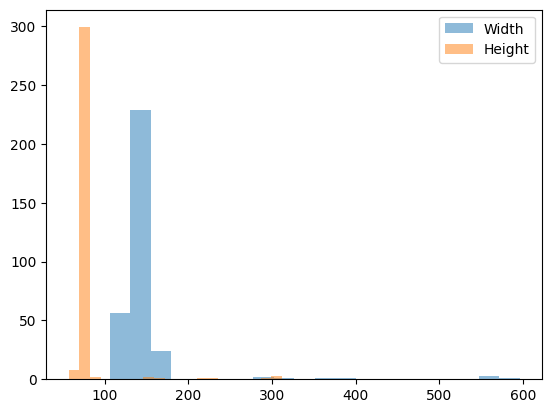

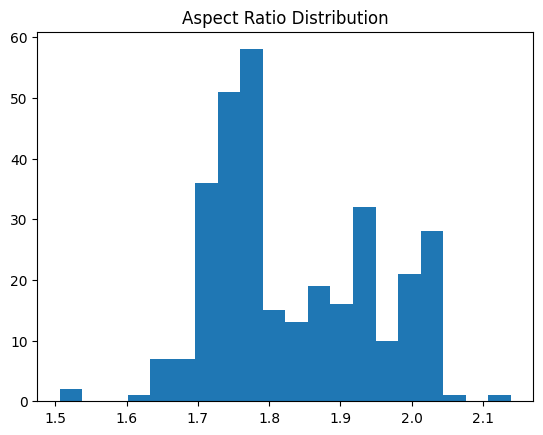

In [118]:
plt.hist(widths, bins=20, alpha=0.5, label='Width')
plt.hist(heights, bins=20, alpha=0.5, label='Height')
plt.legend()
plt.show()

plt.hist(aspect_ratios, bins=20)
plt.title('Aspect Ratio Distribution')
plt.show()